In [ ]:
# Fit the data in the pipeline and get all results
# For the community detection, need to generate a set of trials and pick up the most common one.

In [ ]:
!pip install 'networkx==3.1'
!pip install 'pandas == 2.0.3'
!pip install 'numpy == 1.25.2'
!pip install 'plotly == 5.15.0'
!pip install 'statsmodels.api == 0.14.2'
!pip install 'matplotlib == 3.7.1'
!pip install 'itertools == 3.10.12'
!pip install 'seaborn == 0.13.1'
!pip install 'community == 1.0.0b1'
!pip install 'sklearn == 1.2.2'
!pip install 'pillow == 10.4.0'
!pip install 'kaleido == 0.2.1'
!pip install Counter
!pip install non_normal

ERROR: Could not find a version that satisfies the requirement statsmodels.api==0.14.2 (from versions: none)
ERROR: No matching distribution found for statsmodels.api==0.14.2
ERROR: Could not find a version that satisfies the requirement itertools==3.10.12 (from versions: none)
ERROR: No matching distribution found for itertools==3.10.12
ERROR: Ignored the following yanked versions: 0.0.post2
ERROR: Could not find a version that satisfies the requirement sklearn==1.2.2 (from versions: 0.0, 0.0.post1, 0.0.post4, 0.0.post5, 0.0.post7, 0.0.post9, 0.0.post10, 0.0.post11, 0.0.post12)
ERROR: No matching distribution found for sklearn==1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Counter: filename=Counter-1.0.0-py3-none-any.whl size=5392 sha256=40ad364789b94917b1583cfc3254c64ab6407d6e2b21c56e8aa8df9b01854b93
  Stored in directory: /root/.cache/pip/wheels/08/5b/a0/8f15503db6a45a1d8747bf0f1438411cb37484ac4dfdfe6c0b
Successfully built Counter


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import tree
import matplotlib.cm as cm
import community.community_louvain as lv
from sklearn.metrics.cluster import v_measure_score
from numpy.linalg import eig
from tqdm import tqdm
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
# Louvain
import community.community_louvain as lv
import random
from collections import Counter
from sklearn.metrics import adjusted_rand_score

In [ ]:
random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_stock = pd.read_csv("drive/MyDrive/Project_5/data/stock_30min_official_trading_filled_missing(ffill).csv")
data_crypto = pd.read_csv("drive/MyDrive/Project_5/data/crypto_30min_filled_missing_value(ffill).csv")
data_etf = pd.read_csv("drive/MyDrive/Project_5/data/etfs_filled.csv").drop(columns = ["Unnamed: 0"])
remove_assets = ["GOVT","IEF", "IEI", "UVXY", "VIXM", "VIXY","VXX"]
data_etf = data_etf.drop(columns = remove_assets)

In [ ]:
# Set the index column of each dataset to "date"
data_crypto = data_crypto.set_index("date")
data_crypto_rm_UST = data_crypto.drop(columns = ["UST"])
data_stock = data_stock.set_index("date")
data_etf = data_etf.set_index("date")

In [ ]:
# Get asset names
stock_names = list(data_stock.columns)
crypto_names = list(data_crypto.columns)
index_names = list(data_etf.columns)
asset_names = stock_names + crypto_names + index_names


crypto_names_rm_UST = list(data_crypto.drop(columns = ["UST"]).columns)

In [ ]:
# Merge all three datasets to one dataset
all_data = pd.concat([data_stock, data_crypto, data_etf], axis =1, join = "inner")

In [ ]:
# 221 assets - without UST
all_data = pd.concat([data_stock, data_crypto_rm_UST, data_etf], axis =1, join = "inner")

In [ ]:
all_data

AAPL      ABBV      ABB       ABT       ACN     ADBE  \
date                                                                            
2019-04-01 09:30:00   46.0119   65.8027  16.3608   74.8287  165.3043  269.465   
2019-04-01 10:00:00   45.7218   66.0483  16.4551   74.7213  165.3476  269.495   
2019-04-01 10:30:00   45.8307   65.9746  16.4636   74.7260  165.5674  269.570   
2019-04-01 11:00:00   46.0267   66.0237  16.3908   74.6980  165.6708  270.360   
2019-04-01 11:30:00   46.0267   65.9836  16.4418   74.6140  165.0318  270.640   
...                       ...       ...      ...       ...       ...      ...   
2023-05-03 13:30:00  169.8900  150.4200  36.2100  112.5900  278.0700  353.150   
2023-05-03 14:00:00  170.2450  149.5600  36.2900  112.6750  278.4150  350.840   
2023-05-03 14:30:00  170.0500  148.5600  36.2936  112.7400  278.1250  350.220   
2023-05-03 15:00:00  168.1500  148.9950  36.0600  111.8200  275.2000  345.640   
2023-05-03 15:30:00  167.4650  149.2500  35.9600  111.7300  275.1600  345.250   

                          ADI       ADP      AIR      ALV  ...     ROBT  \
date                                                       ...            
2019-04-01 09:30:00   99.4959  147.6773  32.8144  69.7456  ...  31.8125   
2019-04-01 10:00:00   99.7834  147.5852  33.0416  70.4788  ...  31.8521   
2019-04-01 10:30:00   99.6999  147.9351  32.9235  70.5246  ...  31.9215   
2019-04-01 11:00:00  100.2377  148.4793  32.9037  70.3001  ...  31.9214   
2019-04-01 11:30:00  100.0523  148.3219  32.9830  70.5521  ...  31.9203   
...                       ...       ...      ...      ...  ...      ...   
2023-05-03 13:30:00  183.7100  218.9500  53.9500  84.8400  ...  40.3700   
2023-05-03 14:00:00  184.6533  218.6550  54.2100  85.0850  ...  40.6300   
2023-05-03 14:30:00  184.9700  218.5600  54.2700  85.2700  ...  40.5552   
2023-05-03 15:00:00  183.0700  216.5500  53.7100  84.7150  ...  40.3300   
2023-05-03 15:30:00  182.4000  215.9800  53.8700  84.4300  ...  40.1400   

                          RPG      RPV     SLYG     SLYV      SLY      SOXX  \
date                                                                          
2019-04-01 09:30:00  113.6350  58.4213  57.9693  57.1022  63.6230  183.6368   
2019-04-01 10:00:00  113.5513  58.7792  58.1034  57.3700  63.8498  184.3252   
2019-04-01 10:30:00  113.6513  58.6781  58.0020  57.1233  63.6229  184.3730   
2019-04-01 11:00:00  113.7362  58.6691  57.9210  57.0701  63.5308  184.8797   
2019-04-01 11:30:00  113.7781  58.7333  57.8523  57.0232  63.4908  184.7363   
...                       ...      ...      ...      ...      ...       ...   
2023-05-03 13:30:00  149.8685  74.8200  71.1700  73.4200  81.0100  412.2200   
2023-05-03 14:00:00  149.7800  74.8900  71.4400  73.4700  81.1425  413.8600   
2023-05-03 14:30:00  149.9000  74.9700  71.4500  73.6008  81.2887  414.0400   
2023-05-03 15:00:00  149.1700  74.1200  70.6641  72.6500  80.5900  409.1200   
2023-05-03 15:30:00  148.4000  73.8600  70.4700  72.4300  80.0000  408.0300   

                          SPY   SVXY      XTN  
date                                           
2019-04-01 09:30:00  268.5800  52.46  58.4137  
2019-04-01 10:00:00  268.8349  52.68  59.0457  
2019-04-01 10:30:00  268.9057  52.67  58.9786  
2019-04-01 11:00:00  269.1464  52.67  59.0445  
2019-04-01 11:30:00  269.1120  52.75  59.0445  
...                       ...    ...      ...  
2023-05-03 13:30:00  412.1200  68.33  73.6800  
2023-05-03 14:00:00  412.5700  68.68  74.1900  
2023-05-03 14:30:00  412.1825  68.45  73.9800  
2023-05-03 15:00:00  408.8250  67.36  73.6800  
2023-05-03 15:30:00  407.9900  67.25  73.1950  

[13361 rows x 221 columns]

In [ ]:
def rgb_to_ansi(r, g, b):
      return f"\033[38;2;{int(r*255)};{int(g*255)};{int(b*255)}m"

In [ ]:
class noise_trend_filtering():
  def __init__(self, data):
    self.data = data
    self.names = data.columns

  def log_return_data(self):
    numpy_data = self.data.to_numpy()
    original = numpy_data[:-1]
    onelag = numpy_data[1:]
    logreturns = np.log(onelag) - np.log(original)
    return_data = pd.DataFrame(data = logreturns, columns = self.names)
    return_data["date"] = self.data.reset_index()["date"][1:].values
    return_data["date"] = pd.to_datetime(return_data["date"])
    return_data = return_data.set_index(['date'])
    return return_data

  def statistical_moments_by_row(self, return_data):
    mean_all = return_data.mean(axis = 0)
    var_all = return_data.var(axis = 0)
    std_all = return_data.std(axis = 0)
    skew_all = return_data.skew(axis = 0)
    kurt_all = return_data.kurt(axis = 0)
    return mean_all, std_all, skew_all, kurt_all


  def create_random_timeseries(self):
    return_data = self.log_return_data()
    mean_all,std_all, _, _ = self.statistical_moments_by_row(return_data)
    time_series = np.random.normal(loc= [0.0]*len(self.names), scale= [1.0]*len(self.names), size= (len(return_data),len(self.names)))
    time_series_zero_mean = (time_series - time_series.mean(axis = 0))/time_series.std(axis = 0)
    time_series_random = time_series_zero_mean*std_all.values + mean_all.values
    time_series_random_df = pd.DataFrame(data = time_series_random)
    return time_series_random_df

  def simulate_eigenvalue_empirical(self, num_sample, filename = "empirical_eig.csv"):
    eigenvalue_dict = {}
    for index in tqdm(range(num_sample)):
      matrix_temp = self.create_random_timeseries()
      # Normalize the matrix
      mean_temp = matrix_temp.mean(axis = 0)
      std_temp = matrix_temp.std(axis = 0)
      std_temp[std_temp < 1e-9] = 1e-9
      normalized_temp = (matrix_temp.to_numpy() - mean_temp.values)/std_temp.values
      # correlation matrix
      corr_temp = (1/len(matrix_temp))*normalized_temp.T@normalized_temp
      corr_temp[corr_temp>1.0], corr_temp[corr_temp< -1.0] = 1.0, -1.0
      # Calculate eigenvalues
      eigvals,_ = eig(corr_temp)
      idx = eigvals.argsort()[::-1]
      eigenValues_temp = eigvals[idx] # take all eigenvalues
      eigenvalue_dict["Stamp " + str(index)] = eigenValues_temp
      eigenvalue_dict_df = pd.DataFrame.from_dict(eigenvalue_dict)
      eigenvalue_dict_df.to_csv(filename)

    return eigenvalue_dict_df


  def TW_mean_std_normalized(self, empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p):
    empirical_eigen = pd.read_csv(empirical_eigenvalue_file).drop(columns = ["Unnamed: 0"])
    mean_empirical = []
    std_empirical = []
    for index in tqdm(range(len(empirical_eigen))):
      eigenvalue_ith_empi = empirical_eigen.iloc[index]
      mean_empirical.append(np.mean(eigenvalue_ith_empi))
      std_empirical.append(np.std(eigenvalue_ith_empi))


    mean_empirical = np.array(mean_empirical)
    std_empirical = np.array(std_empirical)

    theory_eigenvalues = pd.read_csv(theoretical_eigenvalue_file).drop(columns = ["Unnamed: 0"])
    n,p = 300,300
    mu_theory = (np.sqrt(n-1) + np.sqrt(p))**2
    sig_theory = (np.sqrt(n-1) + np.sqrt(p))*(1/np.sqrt(n-1) + 1/np.sqrt(p))**(1/3)
    mu_theory_all = np.array([mu_theory]*len(theory_eigenvalues))[:, np.newaxis]
    sig_theory_all = np.array([sig_theory]*len(theory_eigenvalues))[:, np.newaxis]

    normalized_eigen = (theory_eigenvalues - mu_theory_all)/sig_theory_all

    mean_theory = []
    std_theory = []
    for index in tqdm(range(len(normalized_eigen))):
      eigenvalue_ith = normalized_eigen.iloc[index]
      mean_theory.append(np.mean(eigenvalue_ith))
      std_theory.append(np.std(eigenvalue_ith))


    mean_theory = np.array(mean_theory)
    std_theory = np.array(std_theory)

    if len(mean_theory) < len(mean_empirical):
      mean_empirical = mean_empirical[:len(mean_theory)]
      std_empirical = std_empirical[:len(std_theory)]
    elif len(mean_theory) > len(mean_empirical):
      mean_theory = mean_theory[:len(mean_empirical)]
      std_theory = std_theory[:len(std_empirical)]
    else:
      print("equal length")

    mean_normalized = mean_empirical - (std_empirical/std_theory)*mean_theory
    std_normalized = std_empirical/std_theory

    normalized_eigen_empirical = (empirical_eigen[:len(mean_theory)].to_numpy() - mean_normalized[:, np.newaxis])/std_normalized[:, np.newaxis]


    return mean_normalized, std_normalized,normalized_eigen_empirical


  def signal_identifier(self, empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p):
    return_data = self.log_return_data()
    # Get real Correlation Matrix

    me = return_data.mean(axis = 0).values
    st = return_data.std( axis = 0).values
    normalized = (return_data.to_numpy() - me)/st

    # find cross-correlation matrix
    C_real = (1/len(return_data))*(normalized.T@normalized)

    C_real[C_real>1.0], C_real[C_real < -1.0] = 1.0,-1.0

    eigval, eigvec = eig(C_real)

    idx = eigval.argsort()[::-1]
    eigenValues = eigval[idx]
    eigenVectors = eigvec[:,idx]
    original_eigenvalues = eigval[idx]

    # Get the normalized mean and std to normalize the empirical eigenvalues (obtained from correlation matrices)
    mean_normalized, std_normalized, normalized_eigen_empirical = self.TW_mean_std_normalized(empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p)


    # Only take the first len(mean_theory) eigenvalues from the real correlation matrix
    eigenValues = eigenValues[:len(mean_normalized)]
    normalized_eigenValues_real = (eigenValues - mean_normalized)/std_normalized

    print("normalized_eigenValues_real:")
    print(normalized_eigenValues_real)

    accepted_eigenvalues = {}

    for e,i in enumerate(normalized_eigenValues_real):
      sorted_eigenvalues = np.sort(normalized_eigen_empirical[e])
      larger_values = sorted_eigenvalues[sorted_eigenvalues > i]

      if len(larger_values)/len(sorted_eigenvalues) <= 0.05:
        accepted_eigenvalues["Eigen " + str(e+1)] = i
      else:
        break

    return C_real, original_eigenvalues, eigenVectors, accepted_eigenvalues


  # def noise_trend_removal_TW_temp(self, empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p, detrend = False, png_file = "community_TW.png"):
  #   C_real, original_eigenvalues, eigenVectors, accepted_eigenvalues = self.signal_identifier(empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p)
  #   # Removing Noise - Not Removing Trend
  #   sum_lambda = np.sum(original_eigenvalues[len(accepted_eigenvalues):])
  #   count_vec = len(original_eigenvalues[len(accepted_eigenvalues):])
  #   eigenvector_general = sum_lambda/count_vec
  #   C1 = np.zeros_like(C_real)
  #   for i in range(len(original_eigenvalues)):
  #     if i >= len(accepted_eigenvalues):
  #       C1 = C1 + eigenvector_general*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T
  #     else:
  #       C1 = C1 + original_eigenvalues[i]*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T

  #   # Remove the market component
  #   if detrend == True:
  #     C1 = C1 - original_eigenvalues[0]*(eigenVectors[:,0, np.newaxis]@eigenVectors[:,0, np.newaxis].T)


  #   # C1 now is just a covariance matrix because it is not normalized -> need a normalization step

  #   std_c1 = np.sqrt(np.diag(C1))
  #   C1_corr = C1/np.outer(std_c1,std_c1)
  #   C1_corr[C1_corr<-1.0],C1_corr[C1_corr>1.0]=-1.0,1.0

  #   TW_noise_filtered = C1_corr

  #   # Find Distance matrix
  #   D = np.sqrt(2*(1-TW_noise_filtered))
  #   D[D<1e-7] = 0.0

  #   Graph_TW = nx.from_numpy_array(D, create_using= nx.Graph)
  #   MST =  tree.minimum_spanning_edges(Graph_TW, algorithm= "kruskal", data = True)

  #   # Creating a new graph from a MST
  #   # weight_max = []
  #   mst_graph = nx.Graph()
  #   # Add all nodes to the graph
  #   mst_graph.add_nodes_from(self.names)
  #   for (node1, node2, weight) in MST:
  #     # Add each edge and corresponding weight
  #     for _,b in weight.items():
  #       mst_graph.add_edge(self.names[node1], self.names[node2])
  #       mst_graph.edges[self.names[node1], self.names[node2]]["weight"] = 1/b # The higher the weight is, the more similarity between two assets


  #   louvain_partition = lv.best_partition(mst_graph, weight='weight')


  #   # Draw Louvain result
  #   plt.figure(figsize = (15,15))
  #   pos = nx.kamada_kawai_layout(mst_graph)
  #   # color the nodes according to their partition
  #   cmap = cm.get_cmap('rainbow', max(louvain_partition.values()) + 1)
  #   widths = list(nx.get_edge_attributes(mst_graph,'weight').values())

  #   nx.draw(mst_graph, pos, node_size=580, cmap=cmap, node_color=list(louvain_partition.values()), with_labels = True, font_color= 'k', font_size = 14)
  #   #nx.draw_networkx_edges(mst_graph, pos, alpha=0.5)
  #   plt.savefig(png_file,bbox_inches='tight',pad_inches = 0.1)

  #   return louvain_partition

  def noise_trend_removal_TW_D(self, empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p, detrend = False, save_df = False, png_file = "community_TW.png"):

    C_real, original_eigenvalues, eigenVectors, accepted_eigenvalues = self.signal_identifier(empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p)
    # Removing Noise - Not Removing Trend
    sum_lambda = np.sum(original_eigenvalues[len(accepted_eigenvalues):])
    count_vec = len(original_eigenvalues[len(accepted_eigenvalues):])
    eigenvector_general = sum_lambda/count_vec
    C1 = np.zeros_like(C_real)
    for i in range(len(original_eigenvalues)):
      if i >= len(accepted_eigenvalues):
        C1 = C1 + eigenvector_general*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T
      else:
        C1 = C1 + original_eigenvalues[i]*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T

    # Remove the market component
    if detrend == True:
      C1 = C1 - original_eigenvalues[0]*(eigenVectors[:,0, np.newaxis]@eigenVectors[:,0, np.newaxis].T)


    # C1 now is just a covariance matrix because it is not normalized -> need a normalization step

    std_c1 = np.sqrt(np.diag(C1))
    C1_corr = C1/np.outer(std_c1,std_c1)
    C1_corr[C1_corr<-1.0],C1_corr[C1_corr>1.0]=-1.0,1.0

    TW_noise_filtered = C1_corr

    # Find Distance matrix
    D = np.sqrt(2*(1-TW_noise_filtered))
    D[D<1e-7] = 0.0

    Graph_TW = nx.from_numpy_array(D, create_using= nx.Graph)
    MST =  tree.minimum_spanning_edges(Graph_TW, algorithm= "kruskal", data = True)

    # Creating a new graph from a MST
    # weight_max = []
    mst_graph = nx.Graph()
    # Add all nodes to the graph
    mst_graph.add_nodes_from(self.names)
    for (node1, node2, weight) in MST:
      # Add each edge and corresponding weight
      for _,b in weight.items():
        mst_graph.add_edge(self.names[node1], self.names[node2])
        mst_graph.edges[self.names[node1], self.names[node2]]["weight"] = 1/b # The higher the weight is, the more similarity between two assets

    louvain_partition_trials = {}

    for step in tqdm(range(501), "Louvain Processing: "):
      louvain_partition_trials["Step " + str(step)] = lv.best_partition(mst_graph, weight='weight')

    # louvain_partition_trials = list(louvain_partition_trials.values())


    # # print(louvain_partition_trials)
    # dict_tuples = tuple(tuple(d.items()) for d in louvain_partition_trials)
    # # print("dict_tuples: ", louvain_partition_trials)
    # counter = Counter(dict_tuples)

    # # for i,v in counter.items():
    # #   print(dict(i))
    # #   print(v)
    # selected_partition, max_value = counter.most_common(1)[0]
    # selected_partition = dict(selected_partition)


    louvain_partition_trials_df = pd.DataFrame.from_dict(louvain_partition_trials)
    ARI_matrix = np.zeros((len(louvain_partition_trials_df.columns),len(louvain_partition_trials_df.columns)))

    for i in tqdm(range(len(ARI_matrix)), "Matrix Correlation: "):
      for j in range(i+1, len(ARI_matrix)):
        ari_score = adjusted_rand_score(louvain_partition_trials_df["Step " + str(i)].values, louvain_partition_trials_df["Step " + str(j)].values)
        ARI_matrix[i][j] = ari_score
        ARI_matrix[j][i] = ari_score

    sum_matrix = np.sum(ARI_matrix > 0.9999999999999, axis = 1)

    max_pos = np.argmax(sum_matrix)

    print("max value: ", sum_matrix[max_pos])

    selected_partition = dict(louvain_partition_trials["Step "+  str(max_pos)])






    # Draw Louvain result
    plt.figure(figsize = (15,15))
    pos = nx.kamada_kawai_layout(mst_graph)
    # color the nodes according to their partition
    cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)
    widths = list(nx.get_edge_attributes(mst_graph,'weight').values())

    nx.draw(mst_graph, pos, node_size=580, cmap=cmap, node_color=list(selected_partition.values()), with_labels = True, font_color= 'k', font_size = 14)
    #nx.draw_networkx_edges(mst_graph, pos, alpha=0.5)
    plt.savefig(png_file,bbox_inches='tight',pad_inches = 0.1)

    if save_df == True:
      partition_df = pd.DataFrame.from_dict(selected_partition, orient = "index", columns = ["group"])
      partition_df.index.name = "asset"
      partition_df.to_csv(png_file[:-4] + ".csv")

    return MST,louvain_partition_trials, selected_partition


  def noise_trend_removal_TW(self, empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p, detrend = False, save_df = False, png_file = "community_TW.png"):

    C_real, original_eigenvalues, eigenVectors, accepted_eigenvalues = self.signal_identifier(empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p)
    # Removing Noise - Not Removing Trend
    sum_lambda = np.sum(original_eigenvalues[len(accepted_eigenvalues):])
    count_vec = len(original_eigenvalues[len(accepted_eigenvalues):])
    eigenvector_general = sum_lambda/count_vec
    C1 = np.zeros_like(C_real)
    for i in range(len(original_eigenvalues)):
      if i >= len(accepted_eigenvalues):
        C1 = C1 + eigenvector_general*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T
      else:
        C1 = C1 + original_eigenvalues[i]*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T

    # Remove the market component
    if detrend == True:
      C1 = C1 - original_eigenvalues[0]*(eigenVectors[:,0, np.newaxis]@eigenVectors[:,0, np.newaxis].T)


    # C1 now is just a covariance matrix because it is not normalized -> need a normalization step

    std_c1 = np.sqrt(np.diag(C1))
    C1_corr = C1/np.outer(std_c1,std_c1)
    C1_corr[C1_corr<-1.0],C1_corr[C1_corr>1.0]=-1.0,1.0

    TW_noise_filtered = C1_corr

    # Find Distance matrix
    D = np.sqrt(2*(1-TW_noise_filtered))
    D[D<1e-7] = 0.0

    Graph_TW = nx.from_numpy_array(D, create_using= nx.Graph)
    MST =  tree.minimum_spanning_edges(Graph_TW, algorithm= "kruskal", data = True)

    # Creating a new graph from a MST
    # weight_max = []
    mst_graph = nx.Graph()
    # Add all nodes to the graph
    mst_graph.add_nodes_from(self.names)
    for (node1, node2, weight) in MST:
      # Add each edge and corresponding weight
      for _,b in weight.items():
        mst_graph.add_edge(self.names[node1], self.names[node2])
        mst_graph.edges[self.names[node1], self.names[node2]]["weight"] = 1/b # The higher the weight is, the more similarity between two assets

    louvain_partition_trials = {}

    for step in tqdm(range(501), "Louvain Processing: "):
      louvain_partition_trials["Step " + str(step)] = lv.best_partition(mst_graph, weight='weight')

    # louvain_partition_trials = list(louvain_partition_trials.values())


    # # print(louvain_partition_trials)
    # dict_tuples = tuple(tuple(d.items()) for d in louvain_partition_trials)
    # # print("dict_tuples: ", louvain_partition_trials)
    # counter = Counter(dict_tuples)

    # # for i,v in counter.items():
    # #   print(dict(i))
    # #   print(v)
    # selected_partition, max_value = counter.most_common(1)[0]
    # selected_partition = dict(selected_partition)


    louvain_partition_trials_df = pd.DataFrame.from_dict(louvain_partition_trials)
    ARI_matrix = np.zeros((len(louvain_partition_trials_df.columns),len(louvain_partition_trials_df.columns)))

    for i in tqdm(range(len(ARI_matrix)), "Matrix Correlation: "):
      for j in range(i+1, len(ARI_matrix)):
        ari_score = adjusted_rand_score(louvain_partition_trials_df["Step " + str(i)].values, louvain_partition_trials_df["Step " + str(j)].values)
        ARI_matrix[i][j] = ari_score
        ARI_matrix[j][i] = ari_score

    sum_matrix = np.sum(ARI_matrix > 0.9999999999999, axis = 1)

    max_pos = np.argmax(sum_matrix)

    print("max value: ", sum_matrix[max_pos])

    selected_partition = dict(louvain_partition_trials["Step "+  str(max_pos)])






    # Draw Louvain result
    plt.figure(figsize = (15,15))
    pos = nx.kamada_kawai_layout(mst_graph)
    # color the nodes according to their partition
    cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)
    widths = list(nx.get_edge_attributes(mst_graph,'weight').values())

    nx.draw(mst_graph, pos, node_size=580, cmap=cmap, node_color=list(selected_partition.values()), with_labels = True, font_color= 'k', font_size = 14)
    #nx.draw_networkx_edges(mst_graph, pos, alpha=0.5)
    plt.savefig(png_file,bbox_inches='tight',pad_inches = 0.1)

    if save_df == True:
      partition_df = pd.DataFrame.from_dict(selected_partition, orient = "index", columns = ["group"])
      partition_df.index.name = "asset"
      partition_df.to_csv(png_file[:-4] + ".csv")

    return louvain_partition_trials, selected_partition



  def noise_trend_removal_GN(self, detrend = False, save_df = False, png_file = "community_GN.png"):
    return_data = self.log_return_data()
    me = return_data.mean(axis = 0).values
    st = return_data.std( axis = 0).values
    normalized = (return_data.to_numpy() - me)/st

    # find cross-correlation matrix
    C_real = (1/len(return_data))*(normalized.T@normalized)

    C_real[C_real>1.0], C_real[C_real < -1.0] = 1.0,-1.0

    T = return_data.shape[0]
    N = return_data.shape[1]
    eigval, eigvec = eig(C_real)

    idx = eigval.argsort()[::-1]
    eigenValues = eigval[idx]
    eigenVectors = eigvec[:,idx]

    Q = T/N
    lambda_pos = 1 + 1/Q + 2*np.sqrt(1/Q)
    lambda_neg = 1 + 1/Q - 2*np.sqrt(1/Q)

    # Eigenvalues clipping
    sum_lambda = np.sum(eigenValues[eigenValues < lambda_pos])
    count_vec = float(len(eigenValues[eigenValues < lambda_pos]))
    eigenvector_general = sum_lambda/count_vec
    C1 = np.zeros_like(C_real)
    for i in range(len(eigenValues)):
      if eigenValues[i] < lambda_pos:
        C1 = C1 + eigenvector_general*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T
      else:
        C1 = C1 + eigenValues[i]*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T



    # Remove the market component
    if detrend == True:
      C1 = C1 - eigenValues[0]*(eigenVectors[:,0, np.newaxis]@eigenVectors[:,0, np.newaxis].T)


    # C1 now is just a covariance matrix because it is not normalized -> need a normalization step

    std_c1 = np.sqrt(np.diag(C1))
    C1_corr = C1/np.outer(std_c1,std_c1)
    C1_corr[C1_corr<-1.0],C1_corr[C1_corr>1.0]=-1.0,1.0


    # Find Distance matrix
    D = np.sqrt(2*(1-C1_corr))
    D[D<1e-7] = 0.0

    Graph_GN = nx.from_numpy_array(D, create_using= nx.Graph)
    MST =  tree.minimum_spanning_edges(Graph_GN, algorithm= "kruskal", data = True)

    # Creating a new graph from a MST
    # weight_max = []
    mst_graph = nx.Graph()
    # Add all nodes to the graph
    mst_graph.add_nodes_from(self.names)
    for (node1, node2, weight) in MST:
      # Add each edge and corresponding weight
      for _,b in weight.items():
        mst_graph.add_edge(self.names[node1], self.names[node2])
        mst_graph.edges[self.names[node1], self.names[node2]]["weight"] = 1/b # The higher the weight is, the more similarity between two assets

    louvain_partition_trials = {}

    for step in tqdm(range(2001), "Louvain Processing: "):
      louvain_partition_trials["Step " + str(step)] = lv.best_partition(mst_graph, weight='weight')



    louvain_partition_trials_df = pd.DataFrame.from_dict(louvain_partition_trials)
    ARI_matrix = np.zeros((len(louvain_partition_trials_df.columns),len(louvain_partition_trials_df.columns)))

    for i in range(len(ARI_matrix)):
      for j in range(i+1, len(ARI_matrix)):
        ari_score = adjusted_rand_score(louvain_partition_trials_df["Step " + str(i)].values, louvain_partition_trials_df["Step " + str(j)].values)
        ARI_matrix[i][j] = ari_score
        ARI_matrix[j][i] = ari_score

    sum_matrix = np.sum(ARI_matrix > 0.9999999999999, axis = 1)

    max_pos = np.argmax(sum_matrix)

    selected_partition = dict(louvain_partition_trials["Step "+  str(max_pos)])






    # Draw Louvain result
    plt.figure(figsize = (15,15))
    pos = nx.kamada_kawai_layout(mst_graph)
    # color the nodes according to their partition
    cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)
    widths = list(nx.get_edge_attributes(mst_graph,'weight').values())

    nx.draw(mst_graph, pos, node_size=580, cmap=cmap, node_color=list(selected_partition.values()), with_labels = True, font_color= 'k', font_size = 14)
    #nx.draw_networkx_edges(mst_graph, pos, alpha=0.5)
    plt.savefig(png_file,bbox_inches='tight',pad_inches = 0.1)
    if save_df == True:
      partition_df = pd.DataFrame.from_dict(selected_partition, orient= "index", columns = ["group"])
      partition_df.index.name = "asset"
      partition_df.to_csv(png_file[:-4] + ".csv")


    return louvain_partition_trials, selected_partition


  def TW_new_draw(self, empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p, detrend = False, save_df = False, png_file = "community_TW.png", csv_file = "category.csv"):

    C_real, original_eigenvalues, eigenVectors, accepted_eigenvalues = self.signal_identifier(empirical_eigenvalue_file, theoretical_eigenvalue_file, n, p)
    # Removing Noise - Not Removing Trend
    sum_lambda = np.sum(original_eigenvalues[len(accepted_eigenvalues):])
    count_vec = len(original_eigenvalues[len(accepted_eigenvalues):])
    eigenvector_general = sum_lambda/count_vec
    C1 = np.zeros_like(C_real)
    for i in range(len(original_eigenvalues)):
      if i >= len(accepted_eigenvalues):
        C1 = C1 + eigenvector_general*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T
      else:
        C1 = C1 + original_eigenvalues[i]*eigenVectors[:,i, np.newaxis]@eigenVectors[:,i, np.newaxis].T

    # Remove the market component
    if detrend == True:
      C1 = C1 - original_eigenvalues[0]*(eigenVectors[:,0, np.newaxis]@eigenVectors[:,0, np.newaxis].T)


    # C1 now is just a covariance matrix because it is not normalized -> need a normalization step

    std_c1 = np.sqrt(np.diag(C1))
    C1_corr = C1/np.outer(std_c1,std_c1)
    C1_corr[C1_corr<-1.0],C1_corr[C1_corr>1.0]=-1.0,1.0

    TW_noise_filtered = C1_corr

    # Find Distance matrix
    D = np.sqrt(2*(1-TW_noise_filtered))
    D[D<1e-7] = 0.0

    Graph_TW = nx.from_numpy_array(D, create_using= nx.Graph)
    MST =  tree.minimum_spanning_edges(Graph_TW, algorithm= "kruskal", data = True)

    # Creating a new graph from a MST
    # weight_max = []
    mst_graph = nx.Graph()
    # Add all nodes to the graph
    mst_graph.add_nodes_from(self.names)
    for (node1, node2, weight) in MST:
      # Add each edge and corresponding weight
      for _,b in weight.items():
        mst_graph.add_edge(self.names[node1], self.names[node2])
        mst_graph.edges[self.names[node1], self.names[node2]]["weight"] = 1/b # The higher the weight is, the more similarity between two assets





    # Step 1: Load the CSV file (Assume it has 'node' and 'category' columns
    df = pd.read_excel(csv_file)

    # Step 2: Create a mapping of node to category
    node_category = dict(zip(df['Stocks'], df['Sectors']))

    # Step 4: Assign a unique color to each category
    unique_categories = list(set(node_category.values()))
    num_categories = len(unique_categories)
    palette = sns.color_palette("husl", num_categories)

    category_colors = {cat: palette[i] for i, cat in enumerate(unique_categories)}

    # Step 5: Get colors for each node
    node_colors = [category_colors.get(node_category.get(node, 'default'), 'gray') for node in mst_graph.nodes()]
    print("node colors: ", node_colors)

    # Step 6: Draw the graph
    plt.figure(figsize=(15, 15))
    pos = nx.kamada_kawai_layout(mst_graph)
    nx.draw(mst_graph, pos, with_labels=True, node_color=node_colors, edge_color="gray", cmap=plt.cm.Set1, node_size=580)
    plt.show()


    plt.figure(figsize=(3, 3))
    for i, (category, color) in enumerate(category_colors.items()):
        plt.barh(i, 1, color=color)  # Plot horizontal bar for each category
        plt.text(1.02, i, category, va='center', ha='left', fontsize=12)  # Add category name

    plt.yticks([])  # Hide y-axis ticks
    plt.xlabel('Color Display', fontsize=14)
    plt.title('Category Colors', fontsize=16)
    plt.savefig("colors.png")

































In [ ]:
process = noise_trend_filtering(all_data[:2465])

In [ ]:
asset_category = pd.read_excel("drive/MyDrive/Project_5/data/stock_category.xlsx")

100%|██████████| 100/100 [00:00<00:00, 1105.10it/s]


node colors:  [(0.21786710662428366, 0.6656671601322255, 0.7482809385065813), (0.5920891529639701, 0.6418467016378244, 0.1935069134991043), (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.5920891529639701, 0.6418467016378244, 0.1935069134991043), (0.21786710662428366, 0.6656671601322255, 0.7482809385065813), (0.21786710662428366, 0.6656671601322255, 0.7482809385065813), (0.21786710662428366, 0.6656671601322255, 0.7482809385065813), (0.21786710662428366, 0.6656671601322255, 0.7482809385065813), (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.6423044349219739, 0.5497680051256467, 0.9582651433656727), (0.21786710662428366, 0.6656671601322255, 0.7482809385065813), (0.21786710662428366, 0.6656671601322255, 0.7482809385065813), (0.5920891529639701, 0.6418467016378244, 0.1935069134991043), (0.20312757197899856, 0.6881249249803418, 0.5177618167447304), (0.6423044349219739, 0.5497680051256467, 0.9582651433656727), (0.21786710662428366, 0.6656671601322255, 0.7

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


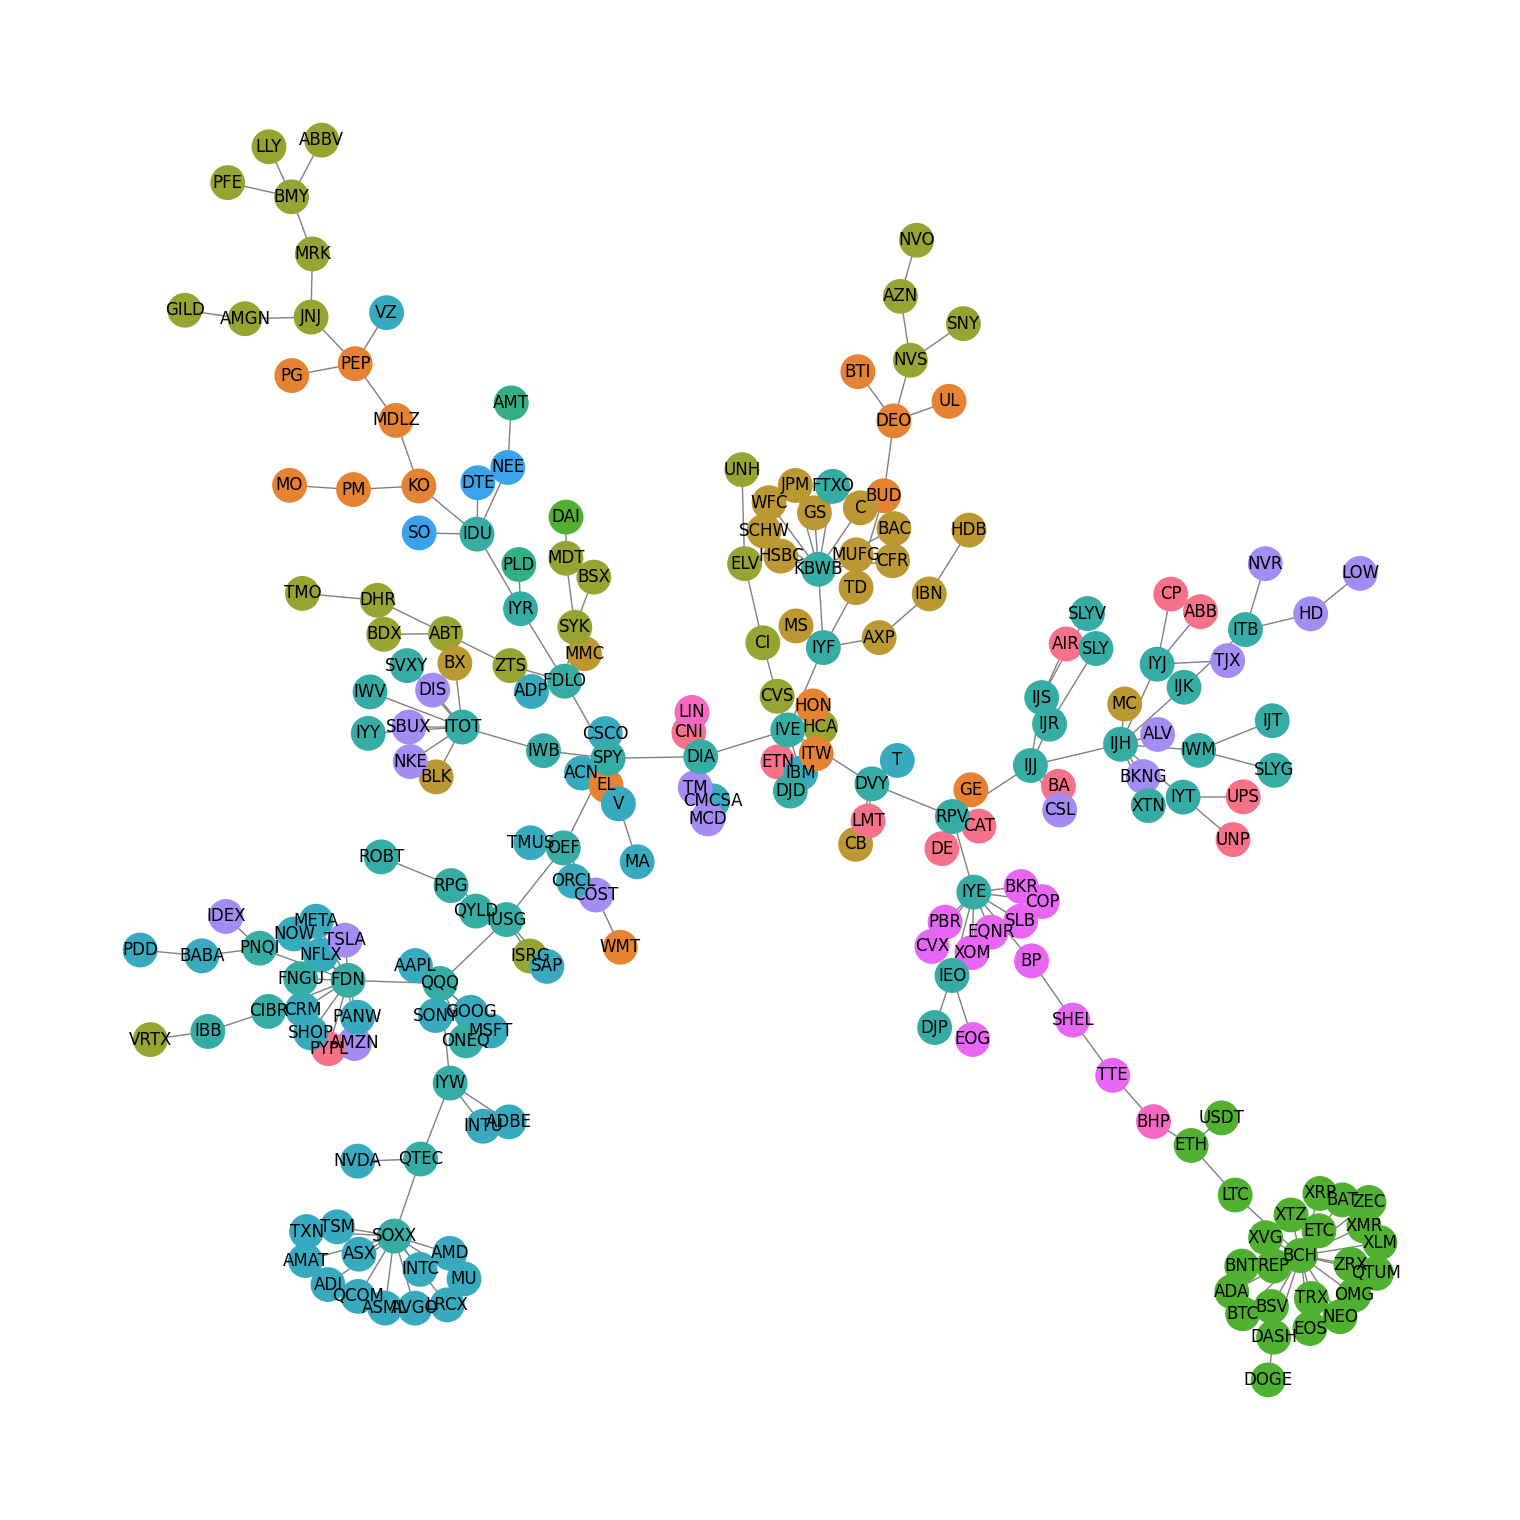

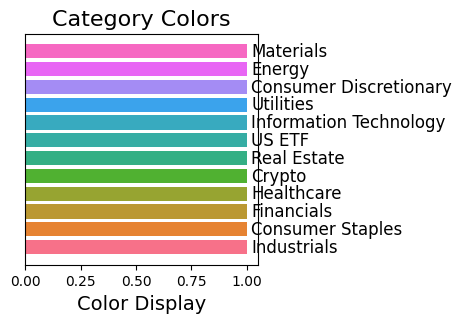

In [ ]:
process.TW_new_draw("drive/MyDrive/Project_5/eigenvalues/empirical_eig_13360x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = False, png_file = "whole_period_221_assets.png", csv_file = "stock_category.xlsx")

In [ ]:
process.signal_identifier("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub1x221_50000.csv", "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300)

100%|██████████| 100/100 [00:00<00:00, 963.15it/s]

normalized_eigenValues_real:
[ 6.38941543e+03  1.01967668e+03  9.27266530e+02  3.69631607e+02
  2.34213064e+02  1.99775584e+02  1.18177999e+02  7.54264253e+01
  6.09801915e+01  5.50862784e+01  3.53826208e+01  2.05401942e+01
  1.38079147e+01  9.44899204e+00  4.58468685e+00 -5.13281705e-01
 -1.30945076e+01 -1.49264469e+01 -2.13236472e+01 -2.23925817e+01
 -2.63121053e+01 -3.07514174e+01 -3.24734396e+01 -3.39147674e+01
 -3.56388573e+01 -3.86557034e+01 -4.00762913e+01 -4.24446483e+01
 -4.44295281e+01 -4.83538714e+01 -4.92359359e+01 -4.99576499e+01
 -5.00016888e+01 -5.43895723e+01 -5.50842607e+01 -5.76801090e+01
 -5.87948518e+01 -5.99864472e+01 -6.05696976e+01 -6.18488306e+01
 -6.34356039e+01 -6.43036450e+01 -6.46680418e+01 -6.61057094e+01
 -6.75670658e+01 -6.91619373e+01 -6.92156580e+01 -7.07299444e+01
 -7.11106699e+01 -7.21972570e+01 -7.29577389e+01 -7.40462607e+01
 -7.42354125e+01 -7.55598731e+01 -7.59239315e+01 -7.67074244e+01
 -7.78410806e+01 -7.80987063e+01 -7.91382779e+01 -7.93265177e

(array([[0.99959416, 0.24582905, 0.44834803, ..., 0.72827441, 0.64725933,
         0.39605294],
        [0.24582905, 0.99959416, 0.18977119, ..., 0.3972914 , 0.34226421,
         0.20093329],
        [0.44834803, 0.18977119, 0.99959416, ..., 0.56966812, 0.51993093,
         0.41407374],
        ...,
        [0.72827441, 0.3972914 , 0.56966812, ..., 0.99959416, 0.87497069,
         0.56230443],
        [0.64725933, 0.34226421, 0.51993093, ..., 0.87497069, 0.99959416,
         0.49243622],
        [0.39605294, 0.20093329, 0.41407374, ..., 0.56230443, 0.49243622,
         0.99959416]]),
 array([7.37389808e+01, 1.31557474e+01, 1.20563209e+01, 5.84126071e+00,
        4.31841538e+00, 3.92186499e+00, 3.00850875e+00, 2.52131157e+00,
        2.35855323e+00, 2.29154901e+00, 2.07009904e+00, 1.90618157e+00,
        1.83033282e+00, 1.77977263e+00, 1.72416433e+00, 1.66635307e+00,
        1.52321766e+00, 1.50169664e+00, 1.42853501e+00, 1.41581983e+00,
        1.37073661e+00, 1.31936845e+00, 1.2985428

In [ ]:
oeig[0]/oeig.sum()

np.float64(0.3337960156719814)

In [ ]:
_,_, TW_distribution = process.TW_mean_std_normalized("drive/MyDrive/Project_5/eigenvalues/empirical_eig_13360x221_50000.csv", "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300)

100%|██████████| 100/100 [00:00<00:00, 1099.09it/s]


In [ ]:
TW_distribution.shape

(100, 50000)

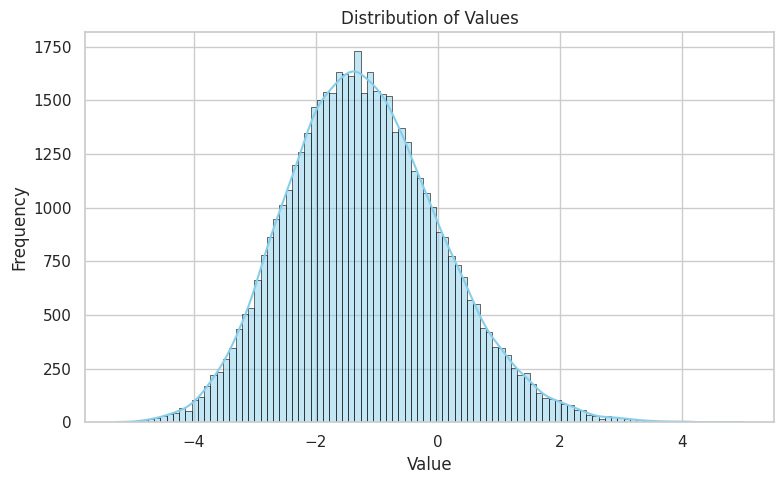

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example list of values
values = TW_distribution[0]

# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 5))
sns.histplot(values, kde=True, bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')

# Show the plot
plt.tight_layout()
plt.show()


AttributeError: Rectangle.set() got an unexpected keyword argument 'bw_adjust'

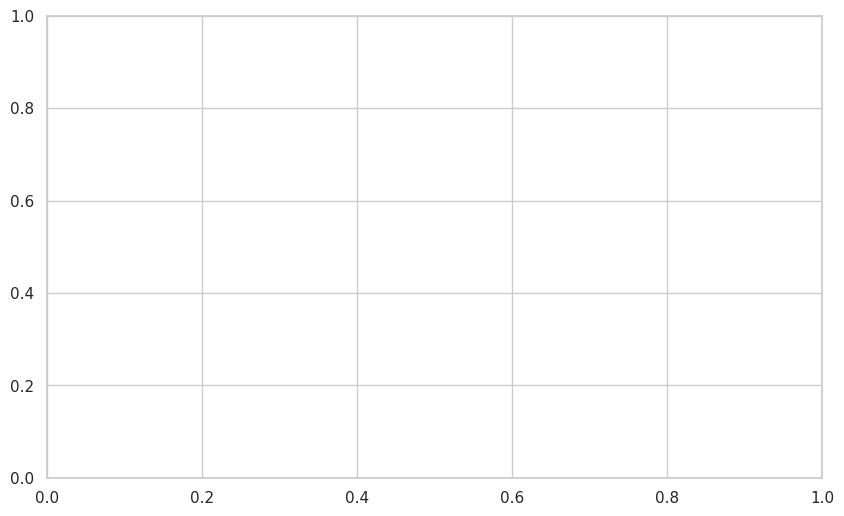

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example lists of values
values1 = TW_distribution[0]
values2 = TW_distribution[1]
values3 = TW_distribution[2]
values4 = TW_distribution[3]
# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot all three distributions
sns.histplot(values1, kde=True, bins=100,bw_adjust=1.2, color='skyblue', label='Group 1', stat='density')
sns.histplot(values2, kde=True, bins=100, color='salmon', label='Group 2', stat='density')
sns.histplot(values3, kde=True, bins=100, color='mediumseagreen', label='Group 3', stat='density')
sns.histplot(values4, kde=True, bins=100, color='mediumseagreen', label='Group 4', stat='density')
# Add labels, legend, and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Comparison of Three Distributions')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


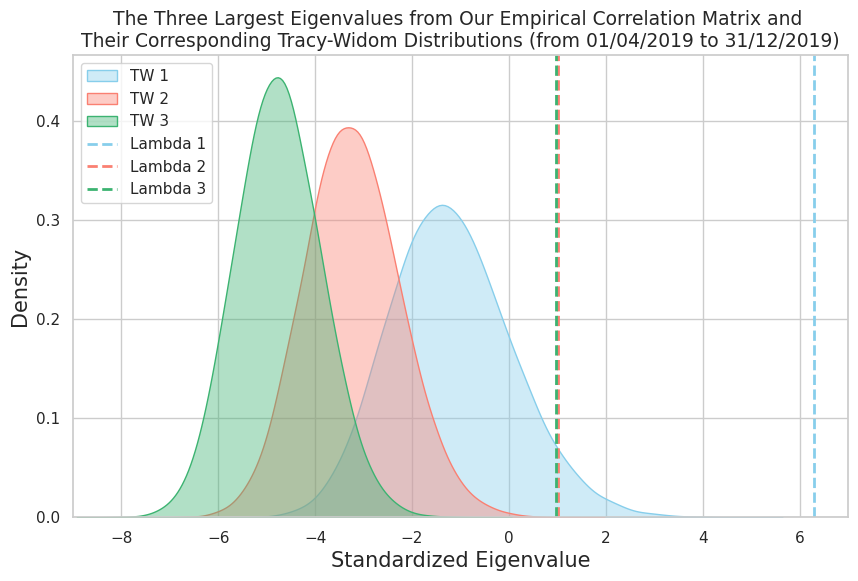

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
group1 = TW_distribution[0]
group2 = TW_distribution[1]
group3 = TW_distribution[2]

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# KDE plots with bw_adjust for smoothness
sns.kdeplot(group1, bw_adjust=1.5, label='TW 1', fill=True, alpha=0.4, color='skyblue')
sns.kdeplot(group2, bw_adjust=1.5, label='TW 2', fill=True, alpha=0.4, color='salmon')
sns.kdeplot(group3, bw_adjust=2.0, label='TW 3', fill=True, alpha=0.4, color='mediumseagreen')
plt.axvline(6.3, color='skyblue', linestyle='--', linewidth=2, label='Lambda 1')
plt.axvline(1.02, color='salmon', linestyle='--', linewidth=2, label='Lambda 2')
plt.axvline(0.97, color='mediumseagreen', linestyle='--', linewidth=2, label='Lambda 3')
plt.xlim(-9.0, 7.0)
# Labels
plt.xlabel('Standardized Eigenvalue', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('The Three Largest Eigenvalues from Our Empirical Correlation Matrix and \nTheir Corresponding Tracy-Widom Distributions (from 01/04/2019 to 31/12/2019)', fontsize = 13.5)
plt.legend()
plt.savefig("drive/MyDrive/Project_5/Tracy_Widom_figures/largest_eigenvalues.png",bbox_inches='tight',pad_inches = 0.1, dpi = 600)


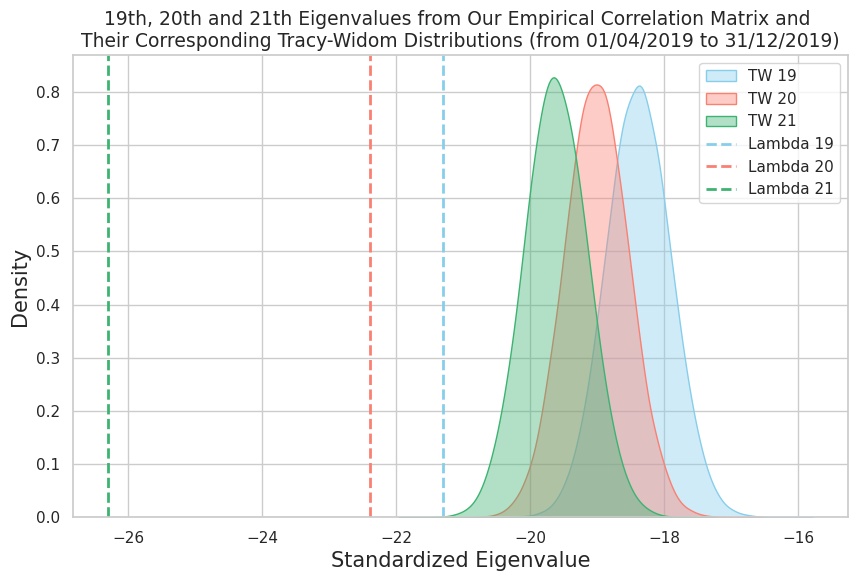

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
group1 = TW_distribution[18]
group2 = TW_distribution[19]
group3 = TW_distribution[20]

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# KDE plots with bw_adjust for smoothness
sns.kdeplot(group1, bw_adjust=1.5, label='TW 19', fill=True, alpha=0.4, color='skyblue')
sns.kdeplot(group2, bw_adjust=1.5, label='TW 20', fill=True, alpha=0.4, color='salmon')
sns.kdeplot(group3, bw_adjust=2.0, label='TW 21', fill=True, alpha=0.4, color='mediumseagreen')
plt.axvline(-21.3, color='skyblue', linestyle='--', linewidth=2, label='Lambda 19')
plt.axvline(-22.4, color='salmon', linestyle='--', linewidth=2, label='Lambda 20')
plt.axvline(-26.3, color='mediumseagreen', linestyle='--', linewidth=2, label='Lambda 21')
# Labels
plt.xlabel('Standardized Eigenvalue', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('19th, 20th and 21th Eigenvalues from Our Empirical Correlation Matrix and \nTheir Corresponding Tracy-Widom Distributions (from 01/04/2019 to 31/12/2019)', fontsize = 13.5)
plt.legend()
plt.savefig("drive/MyDrive/Project_5/Tracy_Widom_figures/small_eigenvalues.png",bbox_inches='tight',pad_inches = 0.1, dpi = 600)


In [ ]:
lv_TW,selected_structure = process.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_13360x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = False, png_file = "whole_period_221_assets.png")

# **Sub-Periods**

The code below is to find the minimum spanning tree and then perform the community detection on this tree.

As explained in our paper, we split our data into 7 distinct periods, corresponding to a major event occurred in financial markets at that time and also the market condition. Thus, depends on which period you want to focus on, the corresponding specification in the code needs to modified. The list of periods are listed below, along with the corresponding specification in the code.

+ Pre-Covid-19 : 04/2019 - 12/2019 -> return_data[:2464]
+ Covid-19     : 01/2020 - 06/2020 -> return_data[2464:4089]
+ Time window 3: 07/2020 - 1/2021 -> return_data[4089:5988]
+ Time window 4: 02/2021 - 08/2021 -> return_data[5988:7912]
+ Time window 5: 09/2021 - 23/02/2022 -> return_data[7912:9479]
+ Time window 6: 24/02/2022 - 09/2022 -> return_data[9479:11455]
+ Ukraine-Russia conflict: 10/2022 - 05/2023 -> return_data[11455:]

An example below is made using the first period, i.e. Pre-Covid-19. Hence, the return_data[:2464] is used.

We note that the Ukraine-Russia conflict period only has 221 assets since the UST asset has been removed during this period due to its crash. Consequently, to run the below code for this period, please use the data named "return_data_ped5"



# Pre-Covid-19

In [ ]:
sub1 = all_data[:2465]

In [ ]:
pre_Covid = noise_trend_filtering(sub1)

100%|██████████| 100/100 [00:00<00:00, 852.53it/s]


normalized_eigenValues_real:
[ 6.38941543e+03  1.01967668e+03  9.27266530e+02  3.69631607e+02
  2.34213064e+02  1.99775584e+02  1.18177999e+02  7.54264253e+01
  6.09801915e+01  5.50862784e+01  3.53826208e+01  2.05401942e+01
  1.38079147e+01  9.44899204e+00  4.58468685e+00 -5.13281705e-01
 -1.30945076e+01 -1.49264469e+01 -2.13236472e+01 -2.23925817e+01
 -2.63121053e+01 -3.07514174e+01 -3.24734396e+01 -3.39147674e+01
 -3.56388573e+01 -3.86557034e+01 -4.00762913e+01 -4.24446483e+01
 -4.44295281e+01 -4.83538714e+01 -4.92359359e+01 -4.99576499e+01
 -5.00016888e+01 -5.43895723e+01 -5.50842607e+01 -5.76801090e+01
 -5.87948518e+01 -5.99864472e+01 -6.05696976e+01 -6.18488306e+01
 -6.34356039e+01 -6.43036450e+01 -6.46680418e+01 -6.61057094e+01
 -6.75670658e+01 -6.91619373e+01 -6.92156580e+01 -7.07299444e+01
 -7.11106699e+01 -7.21972570e+01 -7.29577389e+01 -7.40462607e+01
 -7.42354125e+01 -7.55598731e+01 -7.59239315e+01 -7.67074244e+01
 -7.78410806e+01 -7.80987063e+01 -7.91382779e+01 -7.93265177e

Matrix Correlation: 100%|██████████| 501/501 [02:24<00:00,  3.46it/s]


max value:  35


<ipython-input-18-3919951035>:306: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


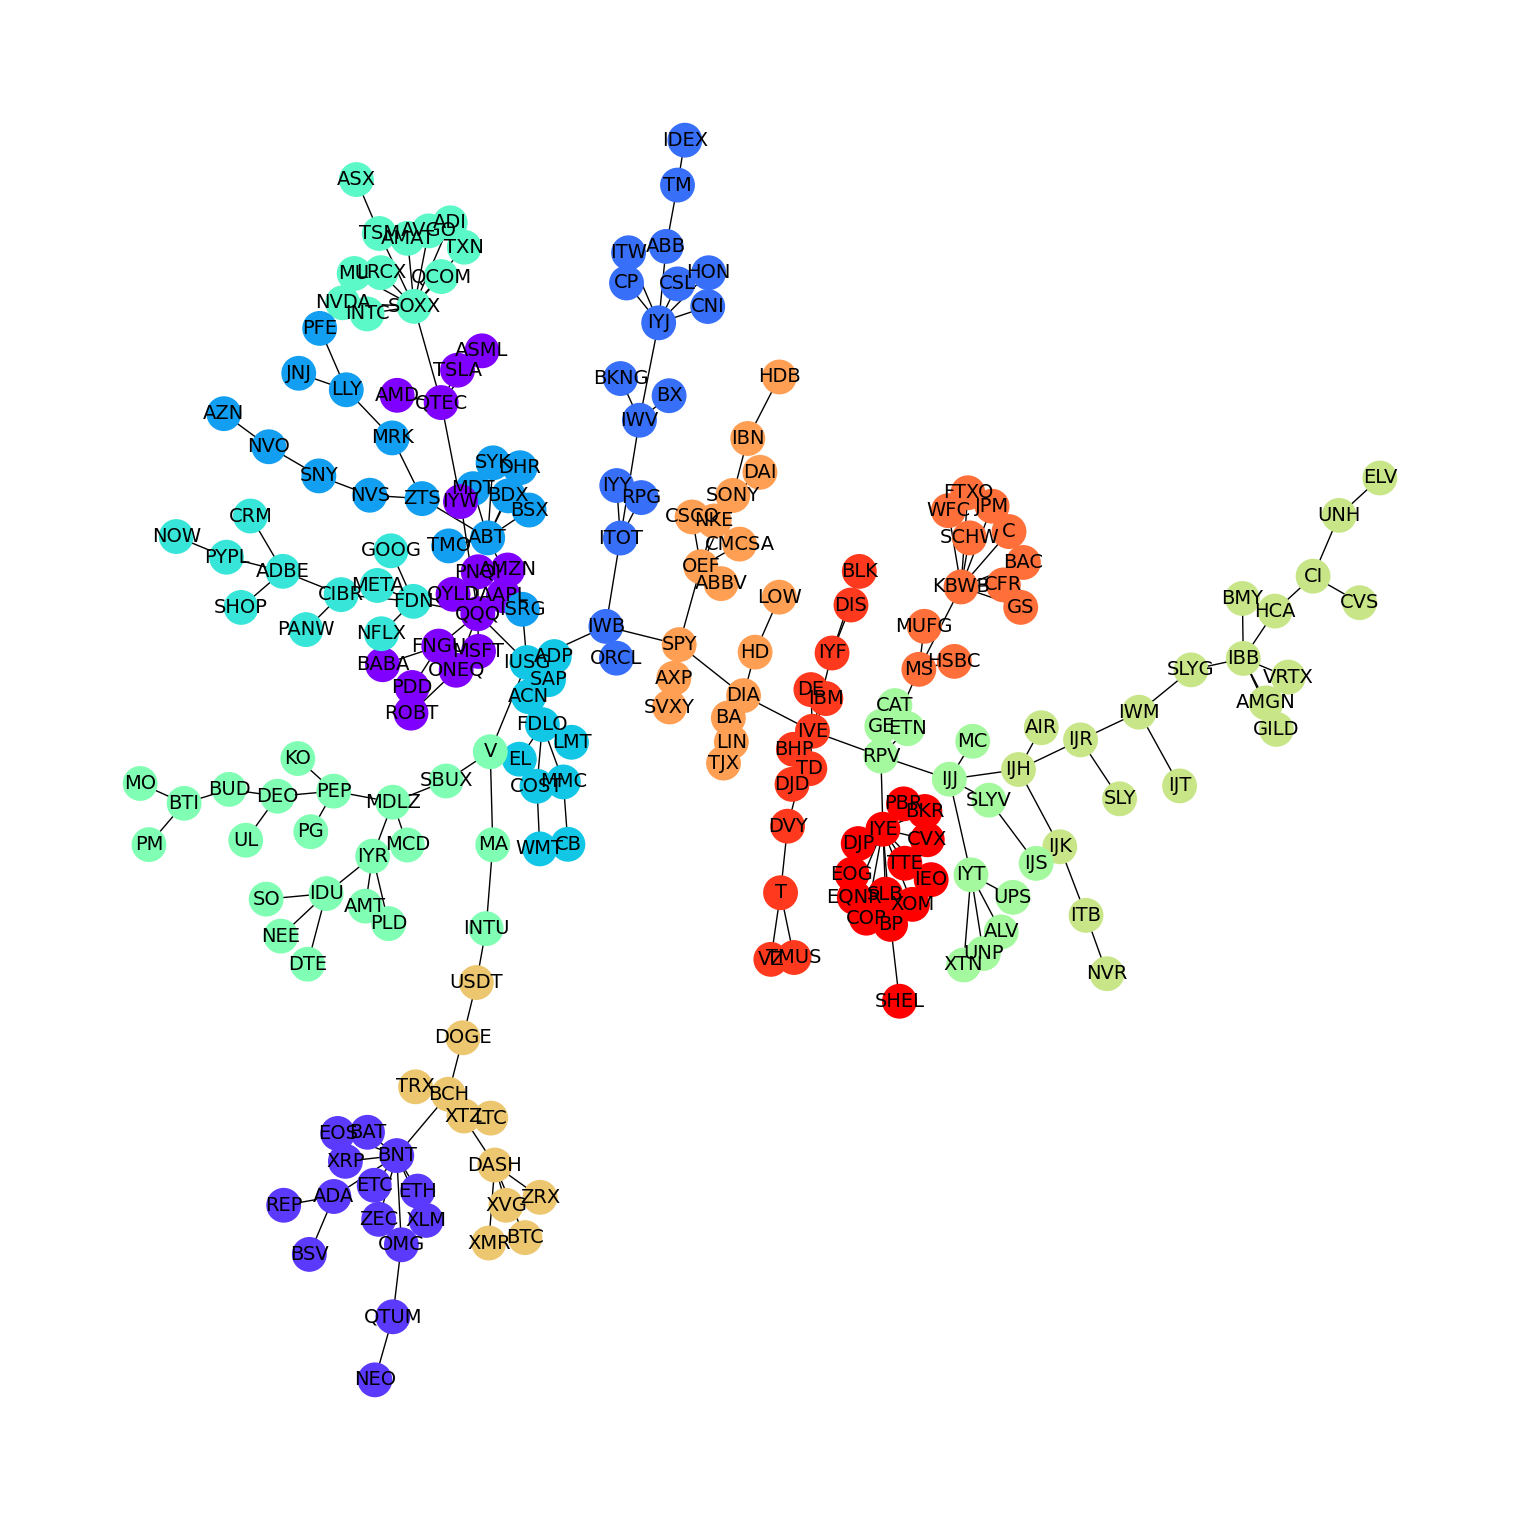

In [ ]:
mst,_,_ = pre_Covid.noise_trend_removal_TW_D("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub1x221_50000.csv","drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv",
                                           300,300)

In [ ]:
D

array([[0.        , 1.16032725, 1.0638104 , ..., 0.9026949 , 0.92498107,
        1.06241217],
       [1.16032725, 0.        , 1.21852008, ..., 1.08378341, 1.10982892,
        1.21040198],
       [1.0638104 , 1.21852008, 0.        , ..., 1.0160315 , 1.02576511,
        1.0437147 ],
       ...,
       [0.9026949 , 1.08378341, 1.0160315 , ..., 0.        , 0.80801731,
        1.00212612],
       [0.92498107, 1.10982892, 1.02576511, ..., 0.80801731, 0.        ,
        1.02570622],
       [1.06241217, 1.21040198, 1.0437147 , ..., 1.00212612, 1.02570622,
        0.        ]])

**Tracy-Widom**

Matrix Correlation: 100%|██████████| 501/501 [02:19<00:00,  3.59it/s]


max value:  36


<ipython-input-154-e0bc4059c2cc>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


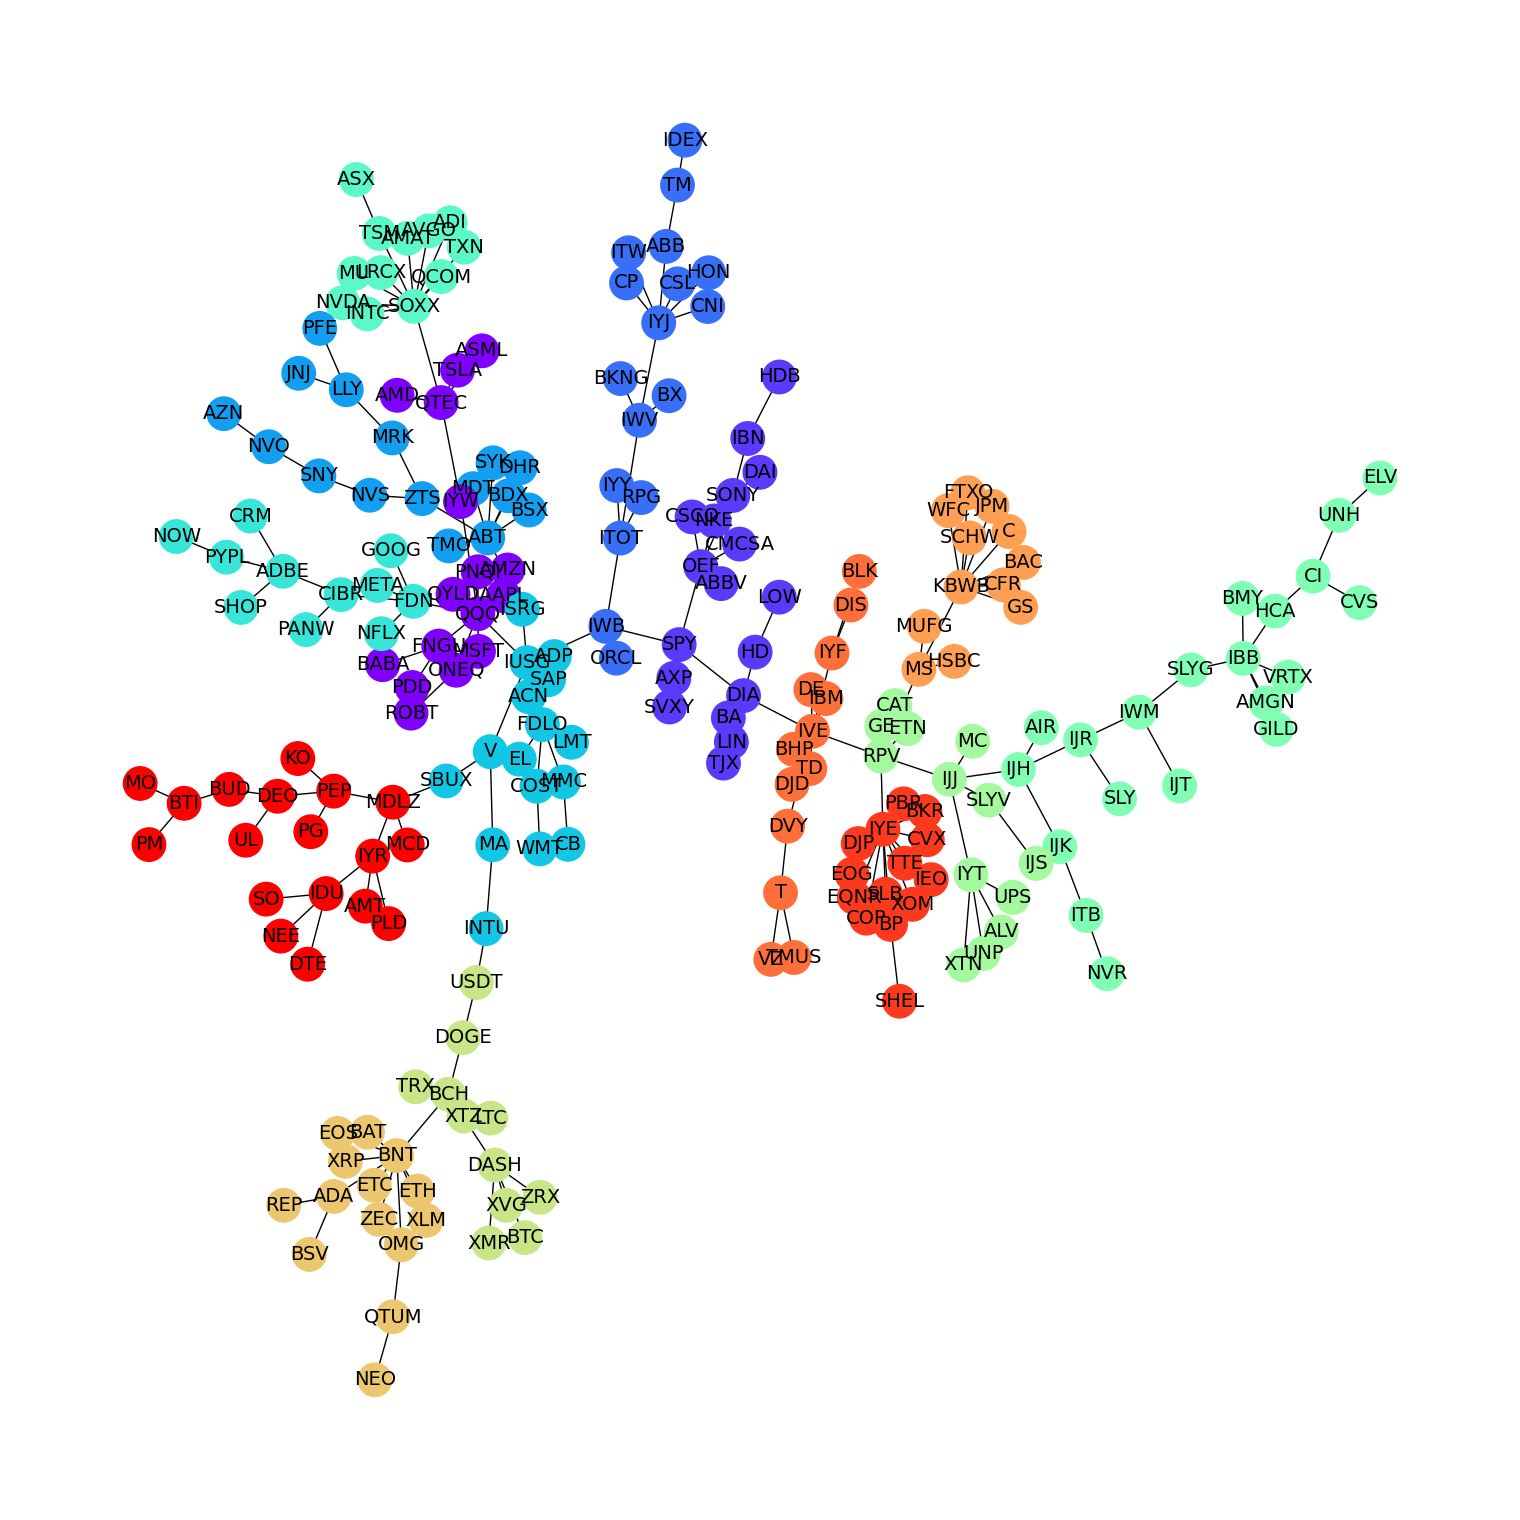

In [ ]:
_,louvain_pre_Covid = pre_Covid.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub1x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/Pre_Covid/Pre_Covid_221_assets_TW.png")

100%|██████████| 100/100 [00:00<00:00, 802.33it/s]


node colors:  [(0.903599057664843, 0.511987276335809, 0.19588350060161624), (0.6423044349219739, 0.5497680051256467, 0.9582651433656727), (0.9633321742064956, 0.40643825645731757, 0.7592537599568671), (0.6423044349219739, 0.5497680051256467, 0.9582651433656727), (0.903599057664843, 0.511987276335809, 0.19588350060161624), (0.903599057664843, 0.511987276335809, 0.19588350060161624), (0.903599057664843, 0.511987276335809, 0.19588350060161624), (0.903599057664843, 0.511987276335809, 0.19588350060161624), (0.9633321742064956, 0.40643825645731757, 0.7592537599568671), (0.20312757197899856, 0.6881249249803418, 0.5177618167447304), (0.903599057664843, 0.511987276335809, 0.19588350060161624), (0.903599057664843, 0.511987276335809, 0.19588350060161624), (0.6423044349219739, 0.5497680051256467, 0.9582651433656727), (0.23299120924703914, 0.639586552066035, 0.9260706093977744), (0.20312757197899856, 0.6881249249803418, 0.5177618167447304), (0.903599057664843, 0.511987276335809, 0.19588350060161624

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


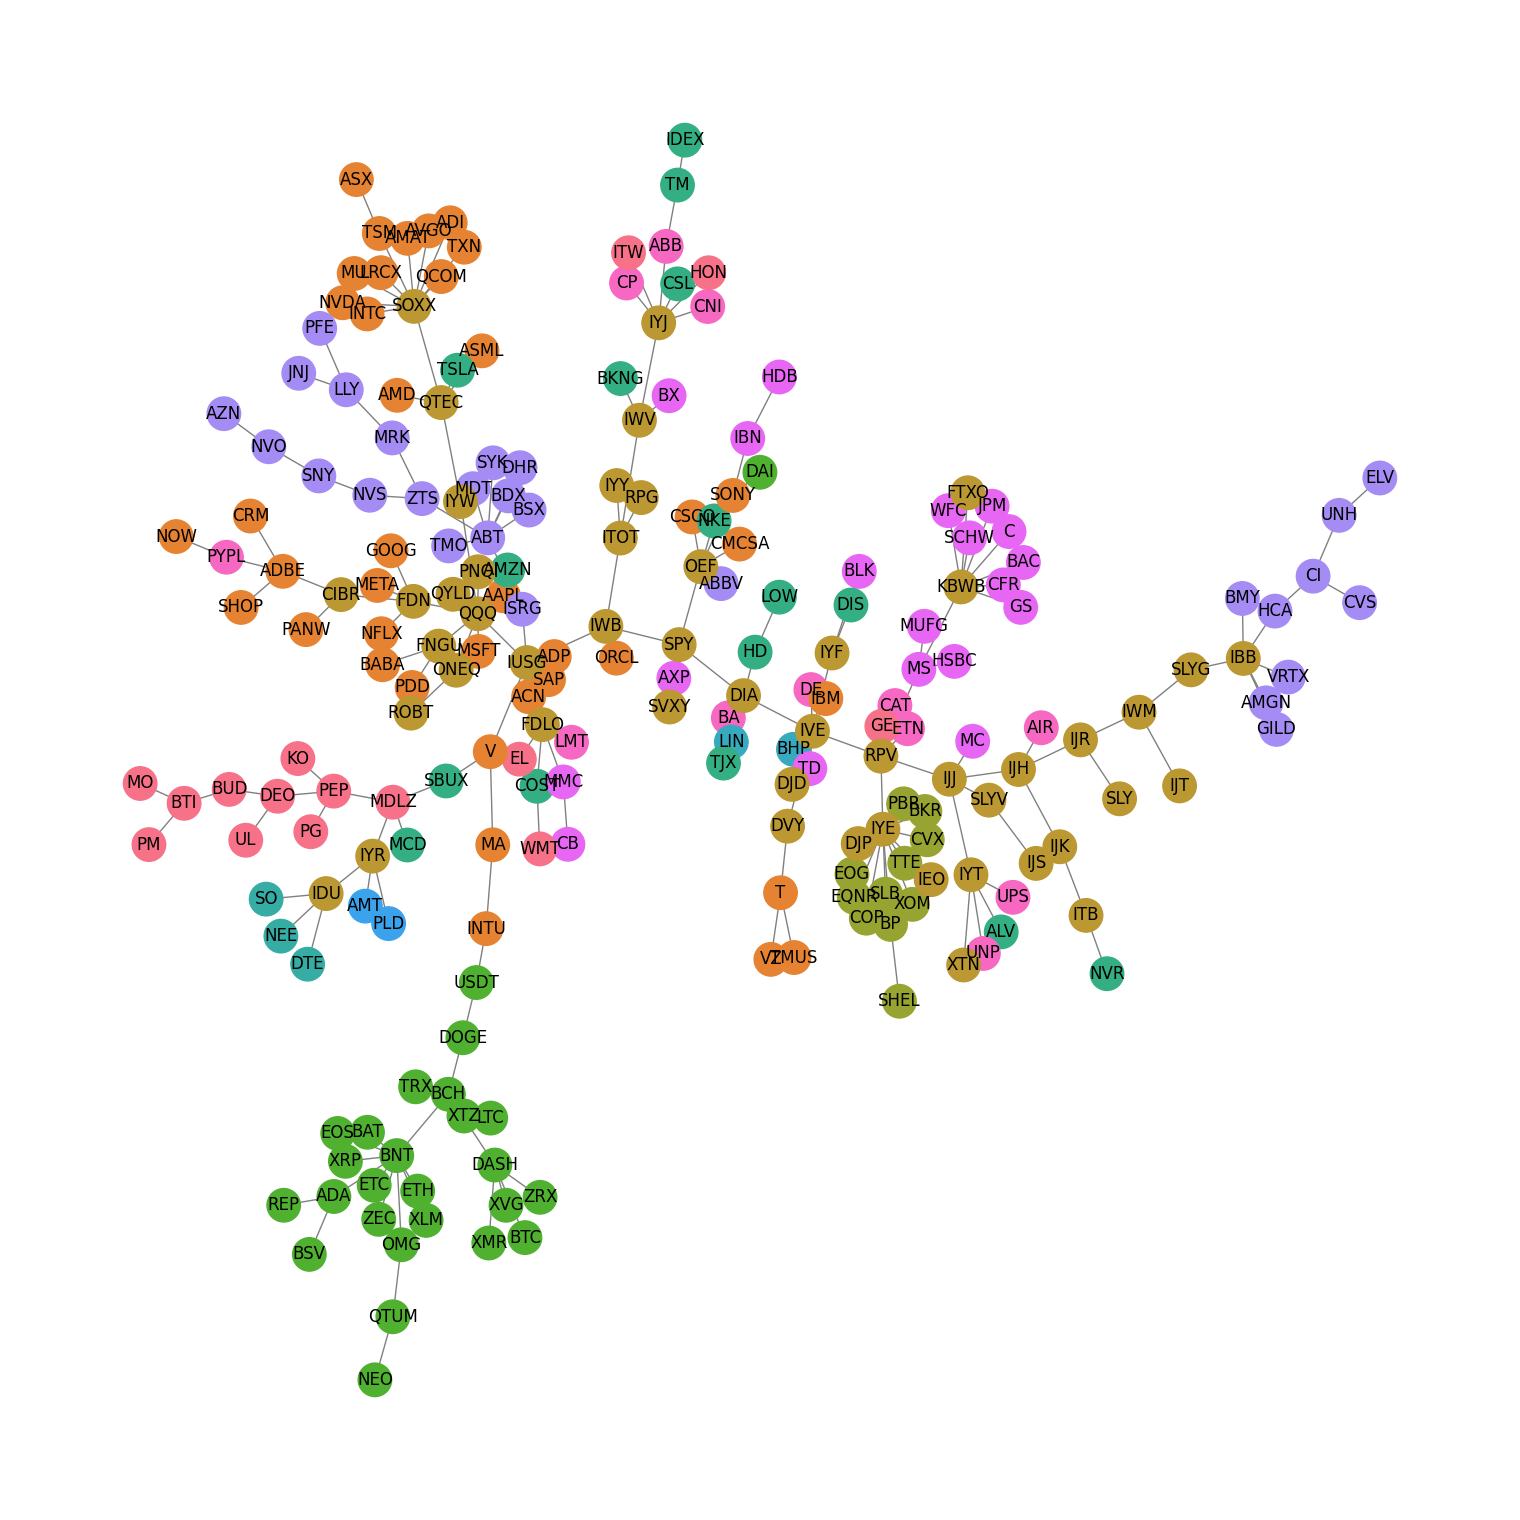

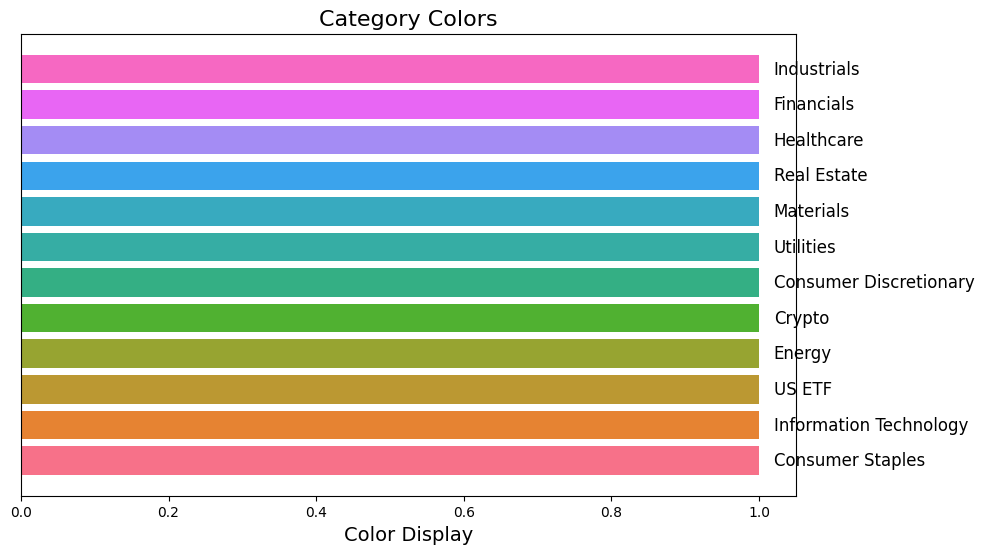

In [ ]:
pre_Covid.TW_new_draw("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub1x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/Pre_Covid/Pre_Covid_221_assets_TW_sectors_allocation.png", csv_file = "stock_category.xlsx")

# Covid-19

In [ ]:
sub2 = all_data[2465:4090]

In [ ]:
Covid = noise_trend_filtering(sub2)

Matrix Correlation: 100%|██████████| 501/501 [02:19<00:00,  3.58it/s]


max value:  232


<ipython-input-154-e0bc4059c2cc>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


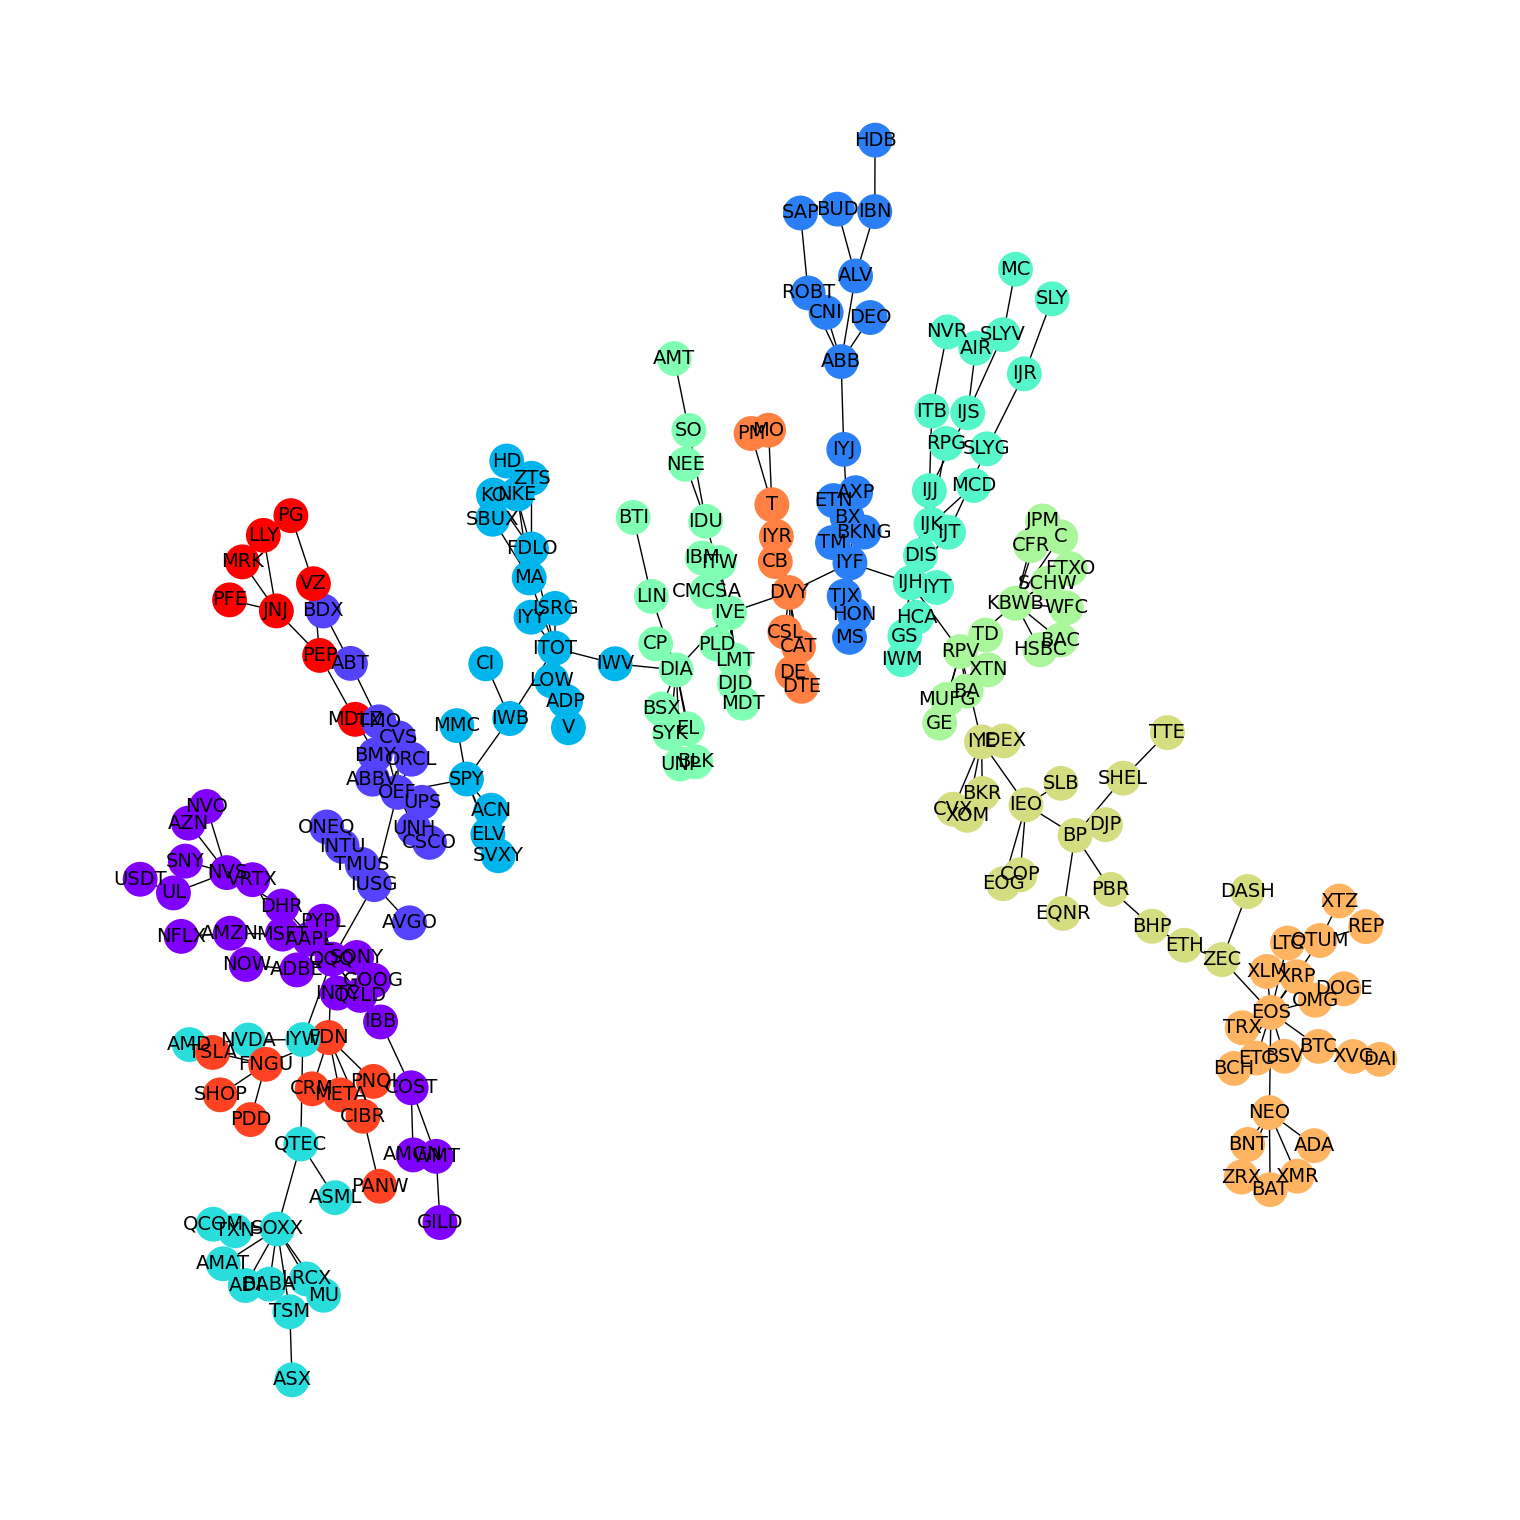

In [ ]:
_,louvain_Covid = Covid.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub2x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/Covid/Covid_221_assets_TW.png")

# Bull Time 1

Matrix Correlation: 100%|██████████| 501/501 [02:20<00:00,  3.57it/s]


max value:  51


<ipython-input-154-e0bc4059c2cc>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


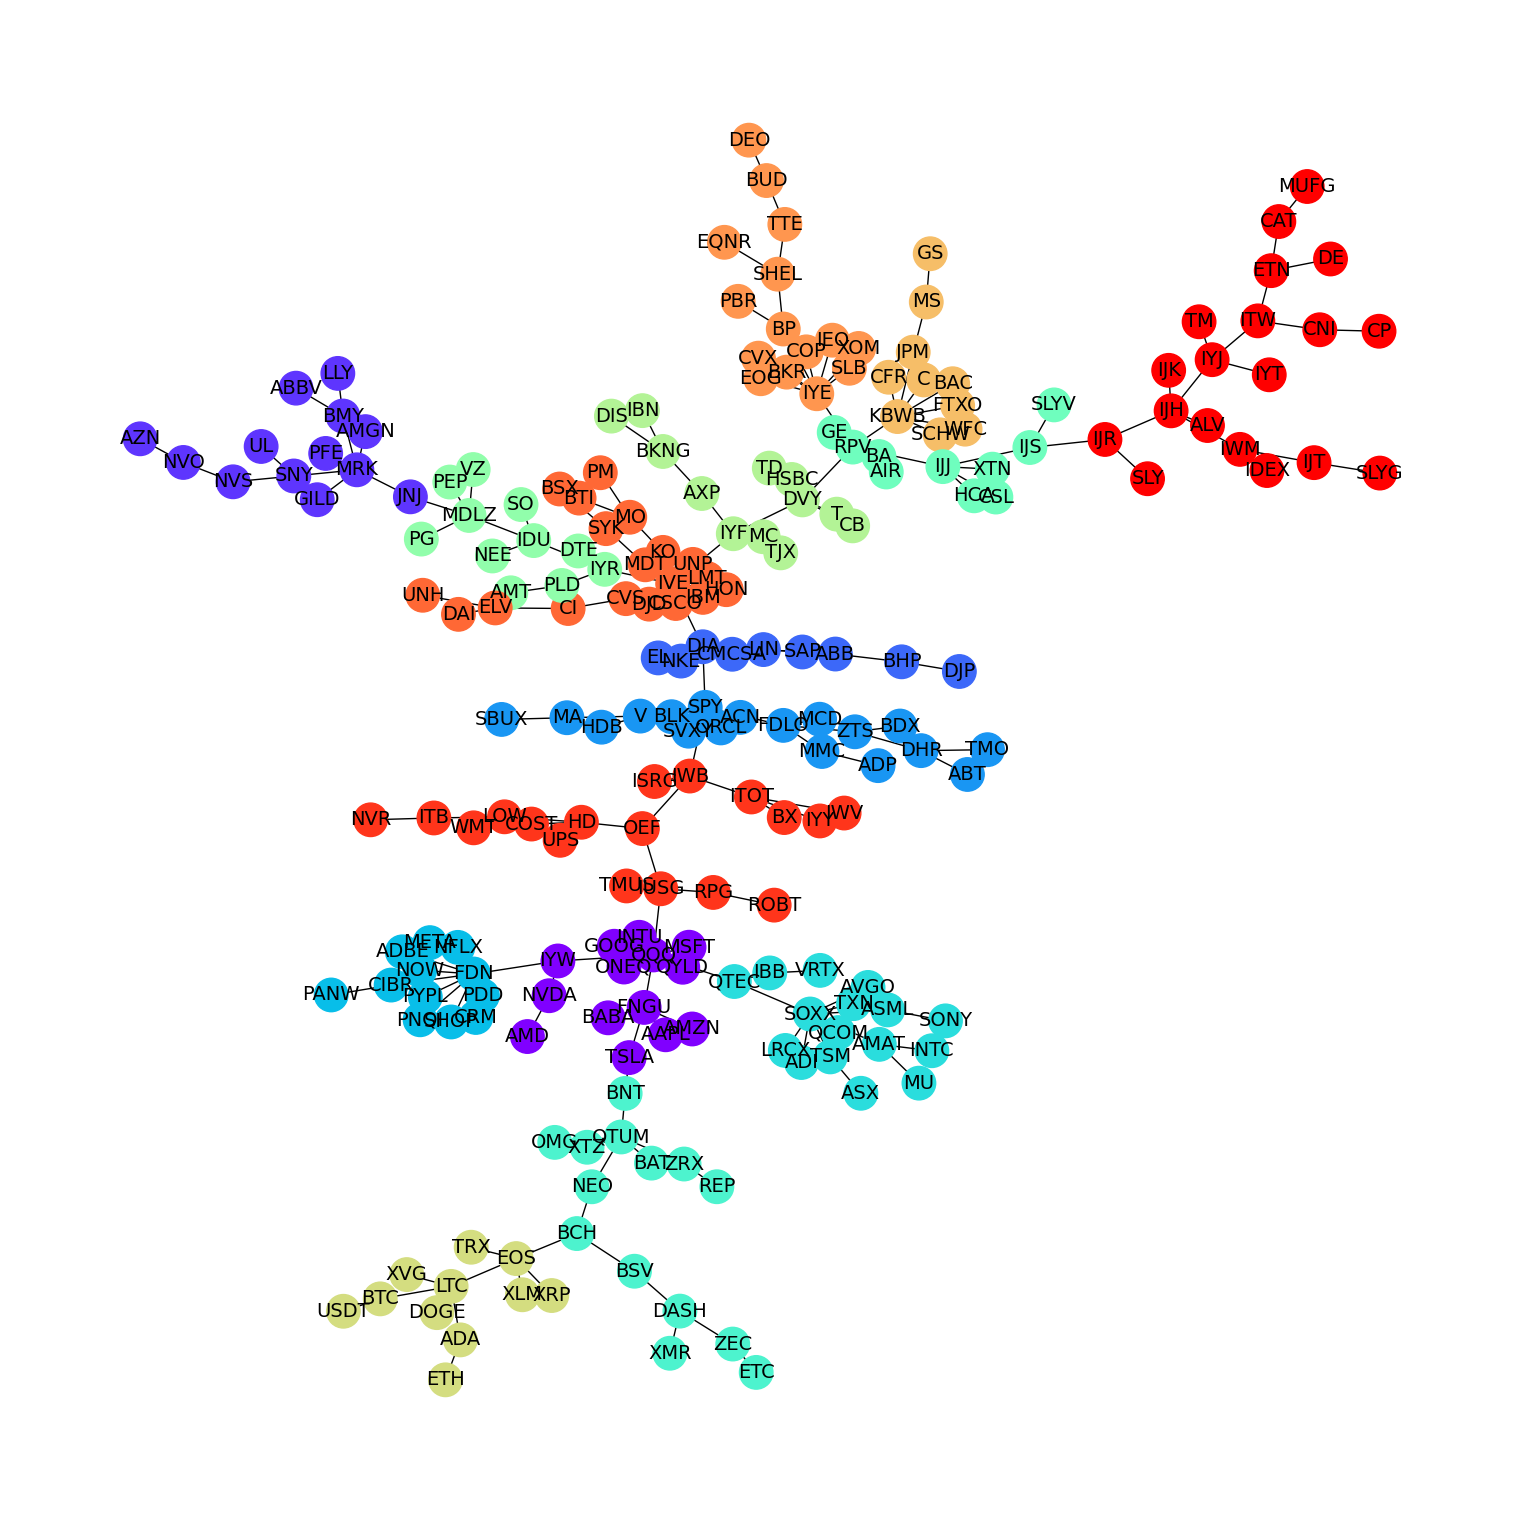

In [ ]:
sub3 = all_data[4090:5989]
Bull_time_1 = noise_trend_filtering(sub3)
_,louvain_Bull_time_1 = Bull_time_1.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub3x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/Bull_Time_1/first_Bull_221_assets_TW.png")

# Bull Time 2

In [ ]:
sub4 = all_data[5989:7913]

Bull_time_2 = noise_trend_filtering(sub4)
Bull_time_2.log_return_data()

AAPL      ABBV       ABB       ABT       ACN  \
date                                                                    
2021-02-01 10:00:00  0.005954 -0.003513  0.005039  0.000000  0.000979   
2021-02-01 10:30:00 -0.000902 -0.003524  0.000169  0.000493  0.002730   
2021-02-01 11:00:00  0.007940 -0.000393  0.001003  0.001284  0.004910   
2021-02-01 11:30:00 -0.001942  0.002646  0.003344  0.002781  0.002798   
2021-02-01 12:00:00  0.008560  0.002638  0.000834  0.002773  0.001271   
...                       ...       ...       ...       ...       ...   
2021-08-31 13:30:00  0.001609  0.000747  0.000000  0.000396  0.001756   
2021-08-31 14:00:00  0.000731  0.001411 -0.000538 -0.001823 -0.001041   
2021-08-31 14:30:00 -0.000666  0.000166 -0.000541 -0.000199  0.001962   
2021-08-31 15:00:00 -0.002694  0.000415 -0.001754 -0.000119 -0.000416   
2021-08-31 15:30:00 -0.000823  0.000580  0.000136  0.002298  0.000416   

                         ADBE       ADI       ADP       AIR       ALV  ...  \
date                                                                   ...   
2021-02-01 10:00:00  0.004514  0.005977  0.001321  0.012430  0.002246  ...   
2021-02-01 10:30:00  0.008861 -0.003992  0.000420 -0.010050  0.002912  ...   
2021-02-01 11:00:00  0.003582  0.003188  0.003322  0.006219  0.004464  ...   
2021-02-01 11:30:00  0.000494  0.003278  0.004085 -0.001773  0.004166  ...   
2021-02-01 12:00:00  0.003458  0.002535 -0.002712 -0.004744 -0.001164  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-31 13:30:00  0.002132 -0.000244  0.001683 -0.000440  0.000679  ...   
2021-08-31 14:00:00  0.000513 -0.000061  0.000096 -0.002935 -0.001244  ...   
2021-08-31 14:30:00  0.001245  0.001403  0.000720 -0.003829 -0.000905  ...   
2021-08-31 15:00:00 -0.000430 -0.004151 -0.001057 -0.005029 -0.002439  ...   
2021-08-31 15:30:00  0.001116 -0.003369  0.004410  0.003848  0.003570  ...   

                         ROBT       RPG       RPV      SLYG      SLYV  \
date                                                                    
2021-02-01 10:00:00  0.003509  0.008040 -0.000318  0.001978 -0.001165   
2021-02-01 10:30:00 -0.004285 -0.000639 -0.002709 -0.007522 -0.000944   
2021-02-01 11:00:00  0.011081  0.002909  0.004616  0.010826  0.008574   
2021-02-01 11:30:00  0.000915  0.002274  0.002680  0.001598 -0.000034   
2021-02-01 12:00:00  0.000732  0.003251 -0.002320  0.000855 -0.002114   
...                       ...       ...       ...       ...       ...   
2021-08-31 13:30:00  0.000527  0.000541  0.000000  0.000190  0.000190   
2021-08-31 14:00:00  0.001061 -0.000295 -0.000772  0.000217  0.001038   
2021-08-31 14:30:00 -0.000883  0.000840 -0.000387  0.000000 -0.000487   
2021-08-31 15:00:00 -0.002667 -0.001431 -0.000774 -0.002389 -0.002727   
2021-08-31 15:30:00  0.001255  0.001377  0.000774  0.001009  0.001412   

                          SLY      SOXX       SPY      SVXY       XTN  
date                                                                   
2021-02-01 10:00:00  0.001295  0.003358  0.000912  0.001109 -0.000493  
2021-02-01 10:30:00 -0.007146 -0.003559 -0.000295  0.003319 -0.005302  
2021-02-01 11:00:00  0.009650  0.007454  0.004736  0.010164  0.006017  
2021-02-01 11:30:00  0.002355  0.001867  0.001387  0.001093  0.004783  
2021-02-01 12:00:00 -0.001118  0.002633  0.002684  0.001364 -0.000346  
...                       ...       ...       ...       ...       ...  
2021-08-31 13:30:00  0.000503  0.000873  0.000597  0.002087 -0.000915  
2021-08-31 14:00:00  0.000729  0.000426 -0.000553  0.001389 -0.001954  
2021-08-31 14:30:00 -0.000410  0.001106  0.000509  0.002080 -0.001462  
2021-08-31 15:00:00 -0.002532 -0.003278 -0.001251 -0.003642 -0.001830  
2021-08-31 15:30:00  0.000992 -0.001686  0.000742  0.005199  0.001106  

[1923 rows x 221 columns]

Matrix Correlation: 100%|██████████| 501/501 [02:19<00:00,  3.60it/s]


max value:  39


<ipython-input-154-e0bc4059c2cc>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


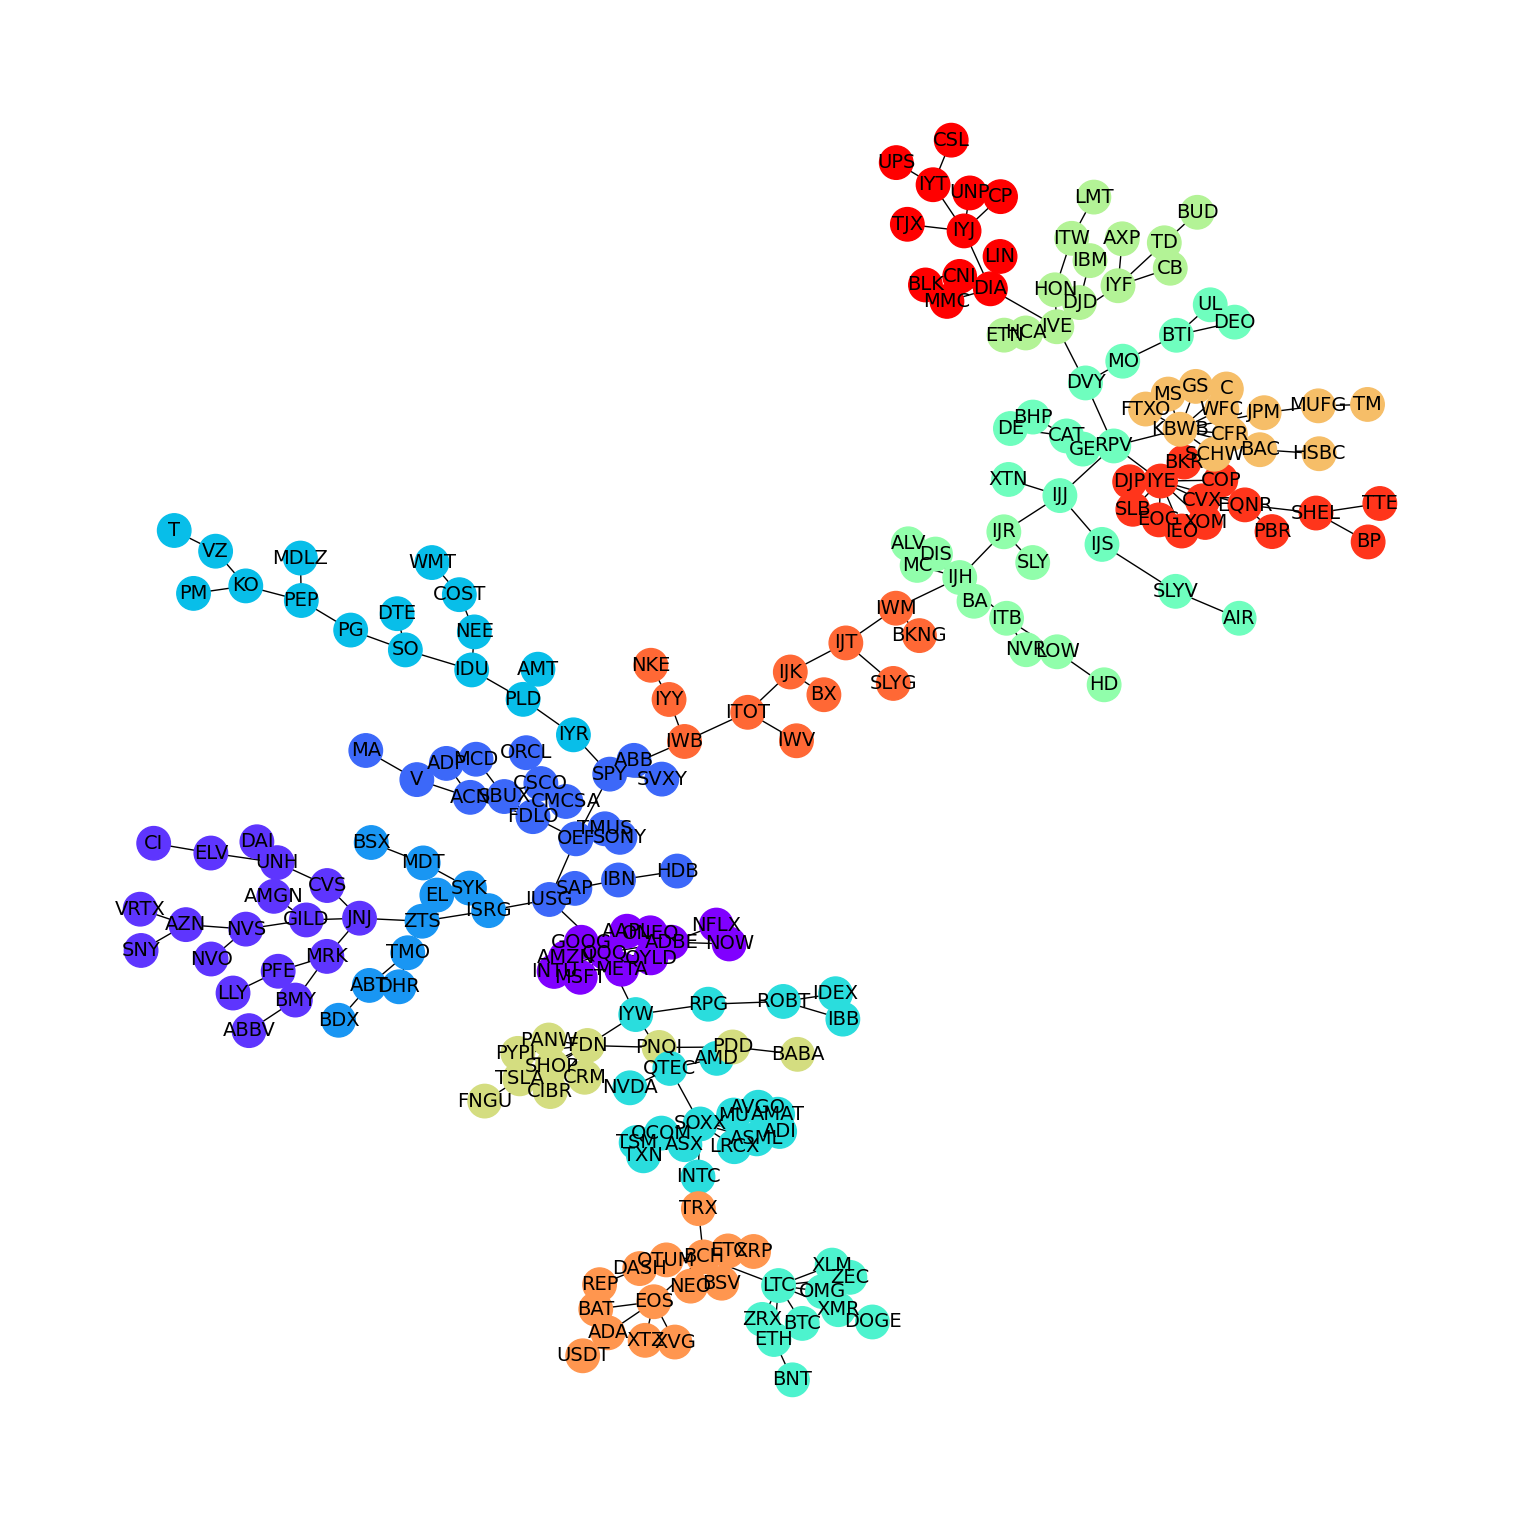

In [ ]:
sub4 = all_data[5989:7913]
Bull_time_2 = noise_trend_filtering(sub4)
_,louvain_Bull_time_2 = Bull_time_2.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub4x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/Bull_Time_2/second_Bull_221_assets_TW.png")

#Bull Time 3

Matrix Correlation: 100%|██████████| 501/501 [02:20<00:00,  3.56it/s]


max value:  47


<ipython-input-154-e0bc4059c2cc>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


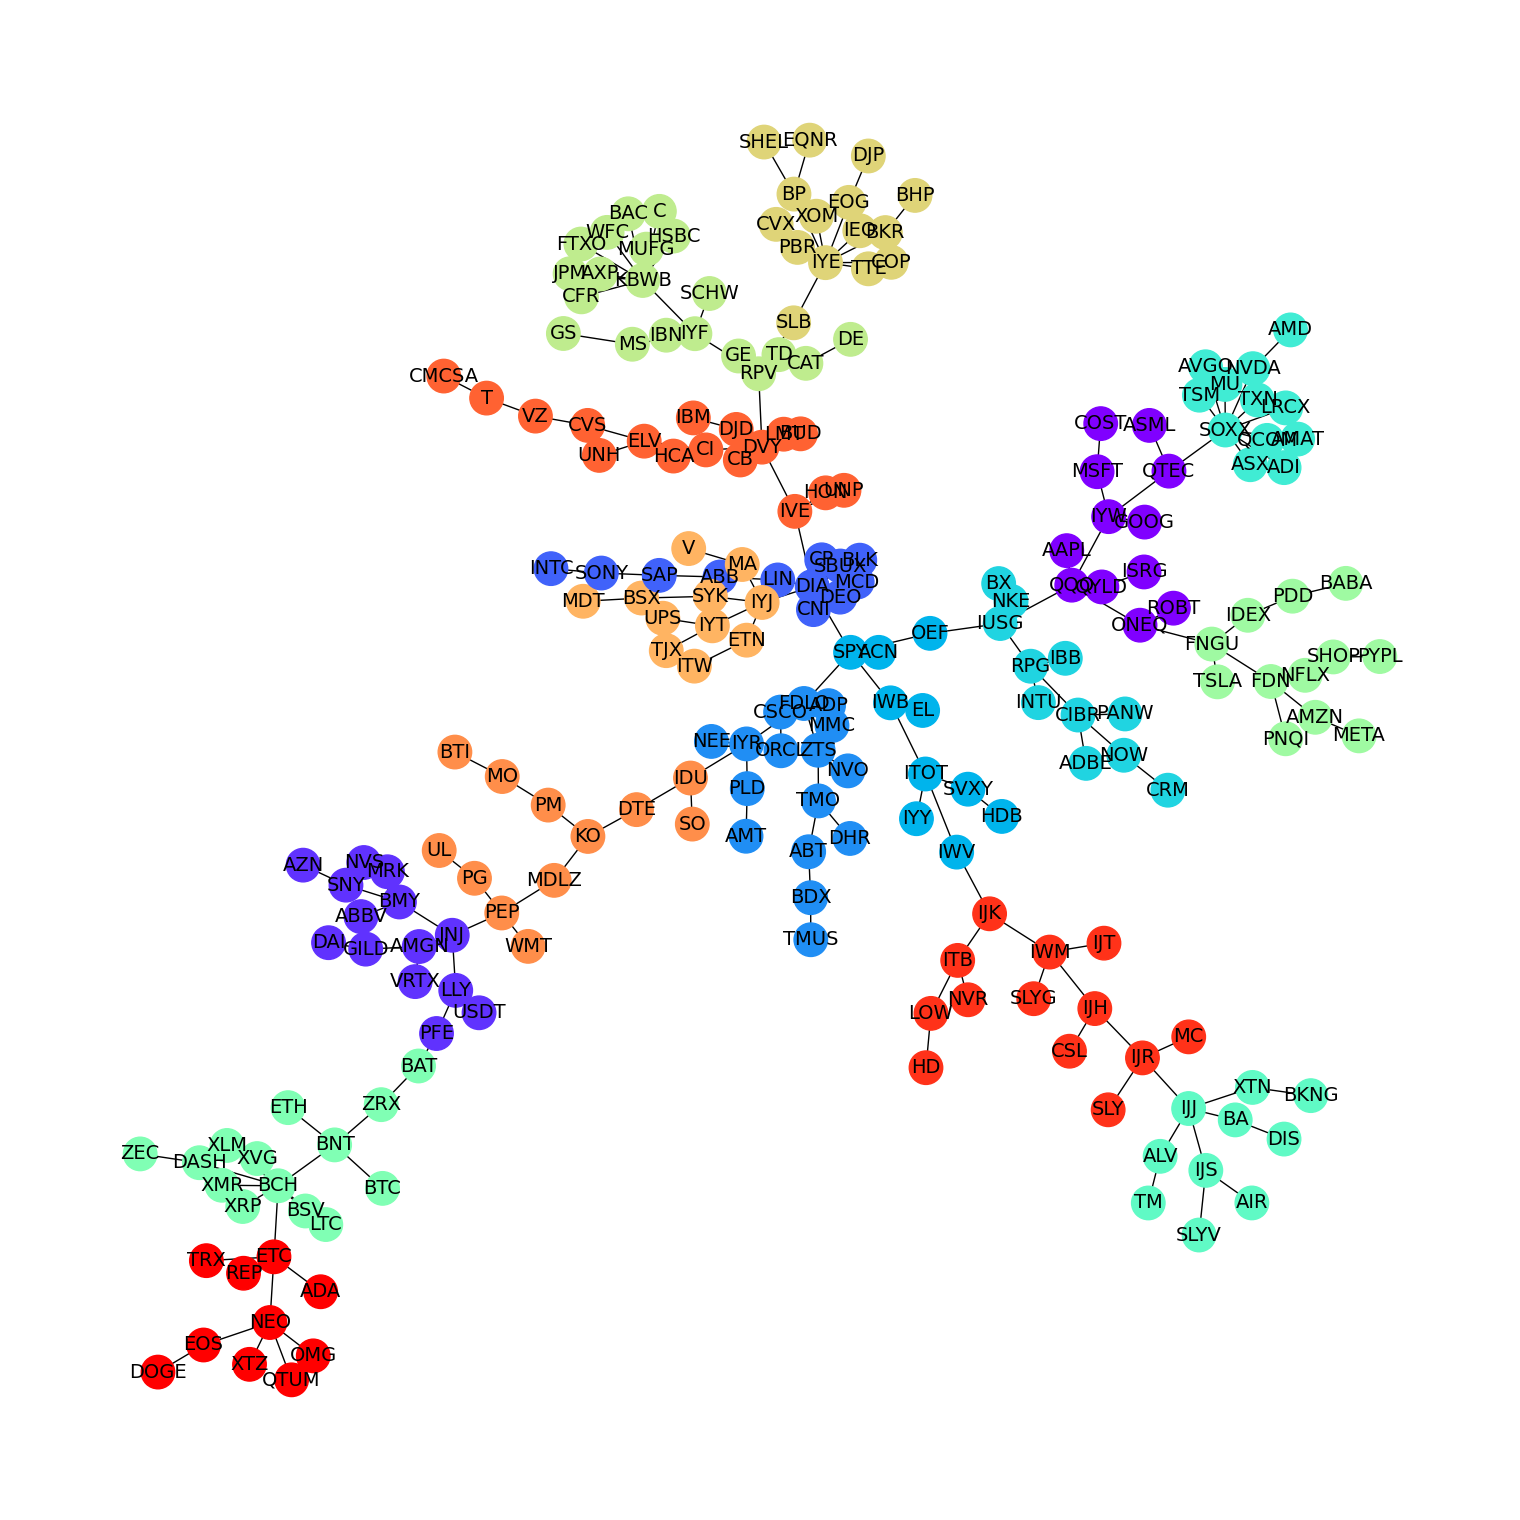

In [ ]:
sub5 = all_data[7913:9480]
Bull_time_3 = noise_trend_filtering(sub5)
_,louvain_Bull_time_3 = Bull_time_3.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub5x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/Bull_Time_3/third_Bull_221_assets_TW.png")

# U-R 1

Matrix Correlation: 100%|██████████| 501/501 [02:19<00:00,  3.60it/s]


max value:  117


<ipython-input-154-e0bc4059c2cc>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


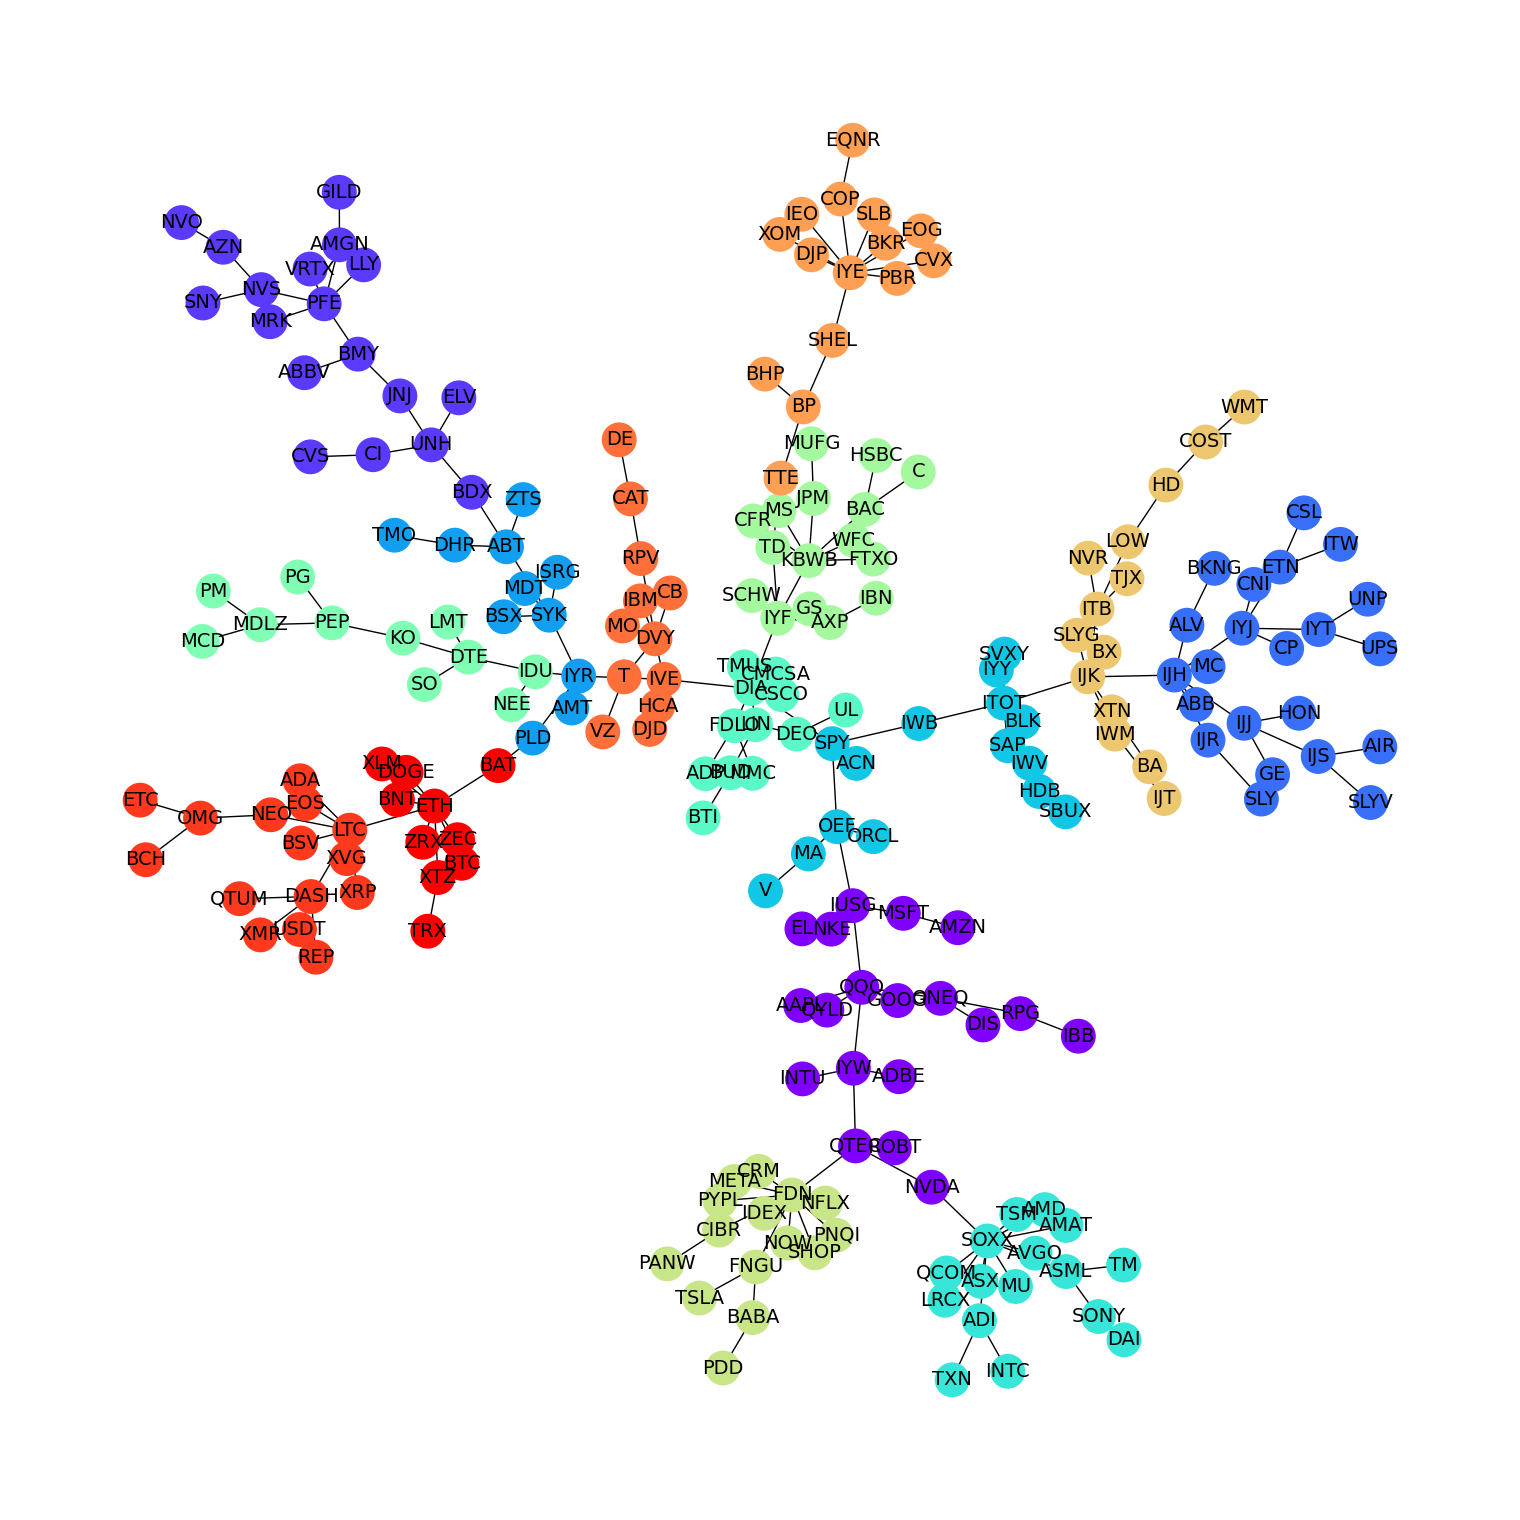

In [ ]:
sub6 = all_data[9480:11456]
U_R_1 = noise_trend_filtering(sub6)
_,louvain_U_R_1 = U_R_1.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub6x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/U_R_1/first_U_R_221_assets_TW.png")

# U-R 2

Matrix Correlation: 100%|██████████| 501/501 [02:20<00:00,  3.58it/s]


max value:  78


<ipython-input-154-e0bc4059c2cc>:304: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


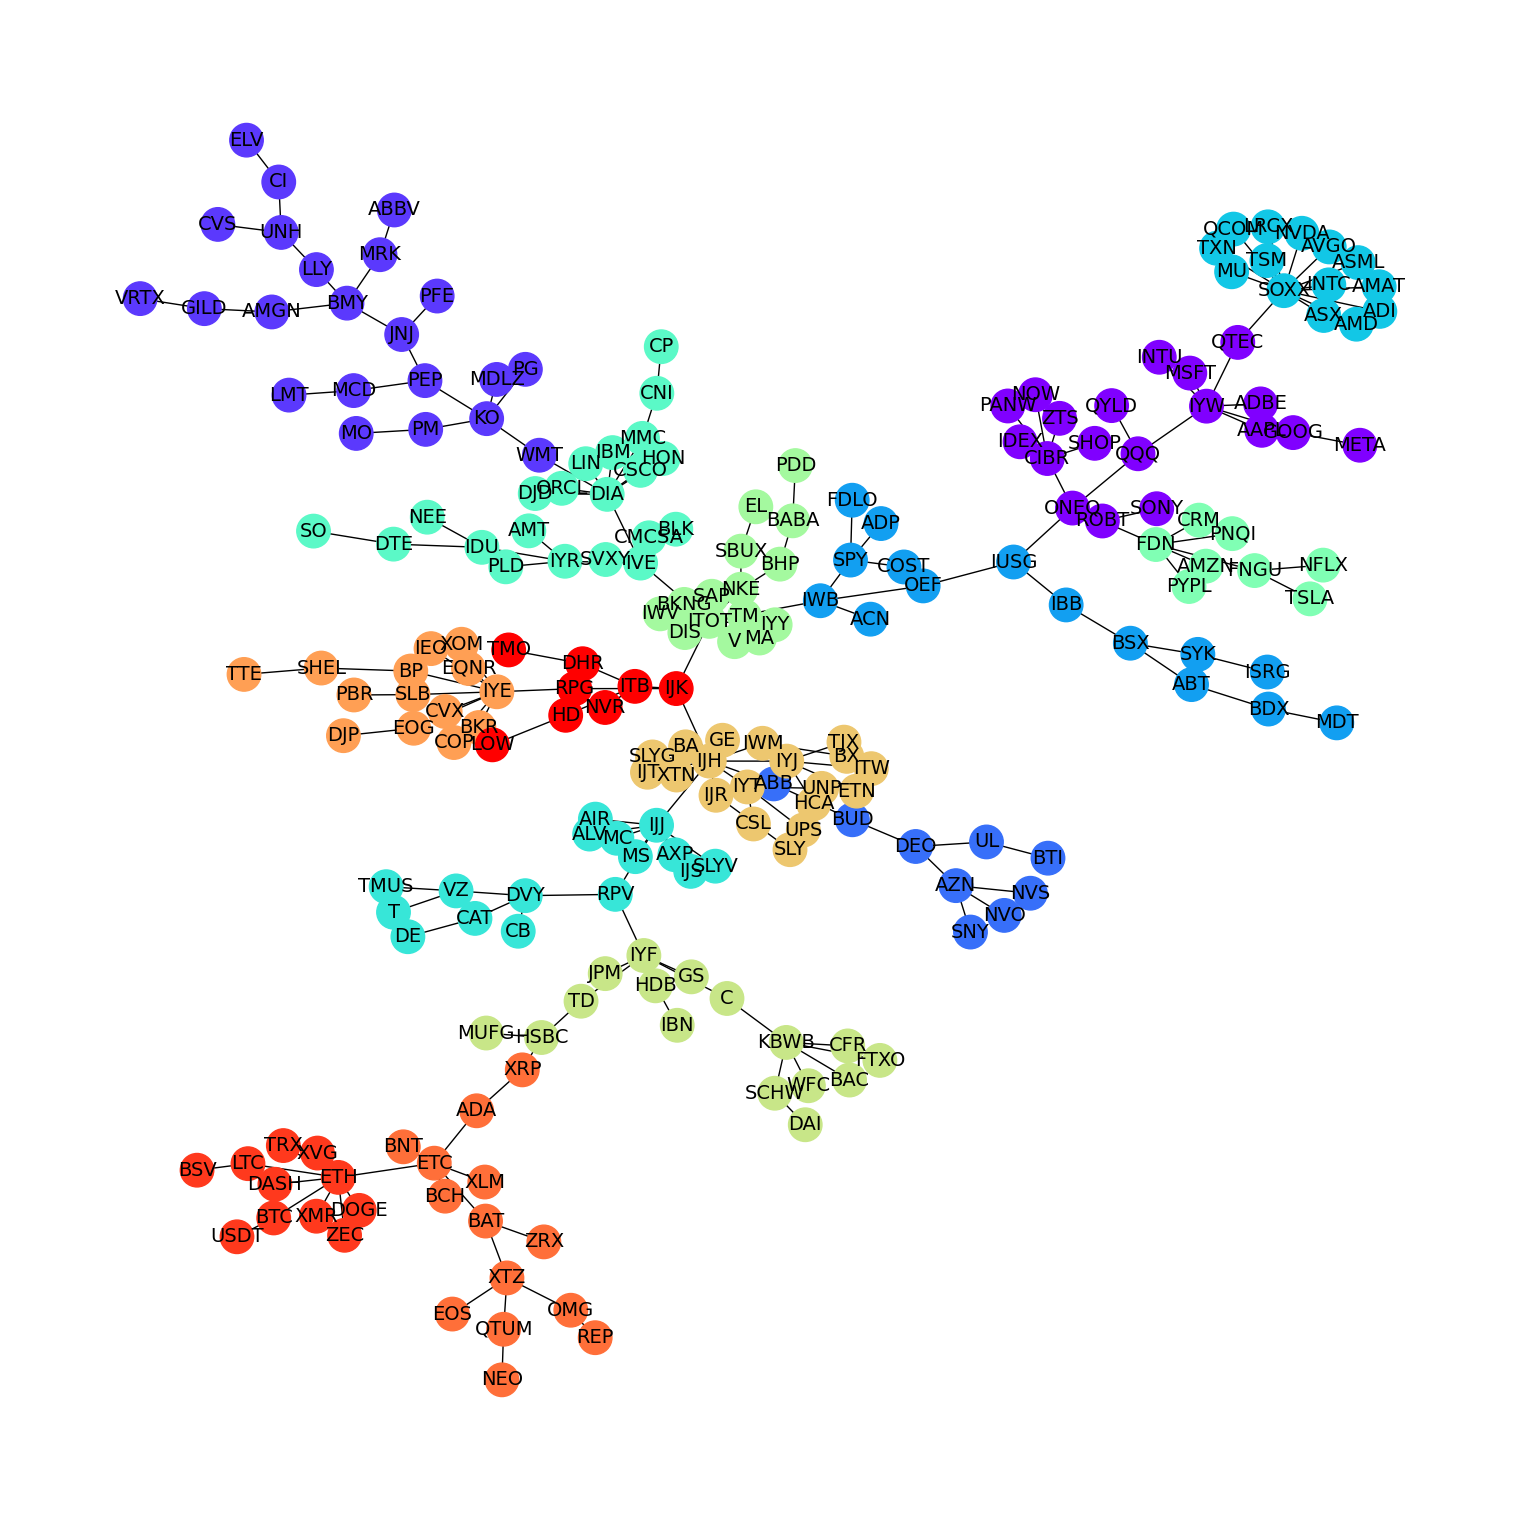

In [ ]:
sub7 = all_data[11456:]
U_R_2 = noise_trend_filtering(sub7)
_,louvain_U_R_2 = U_R_2.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_sub7x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, save_df = True, png_file = "drive/MyDrive/Project_5/Community_detection/U_R_2/second_U_R_221_assets_TW.png")

**Marcenko-Pastur**

Louvain Processing: 100%|██████████| 1001/1001 [00:09<00:00, 108.40it/s]


max value:  11


<ipython-input-10-d732a2efc050>:395: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


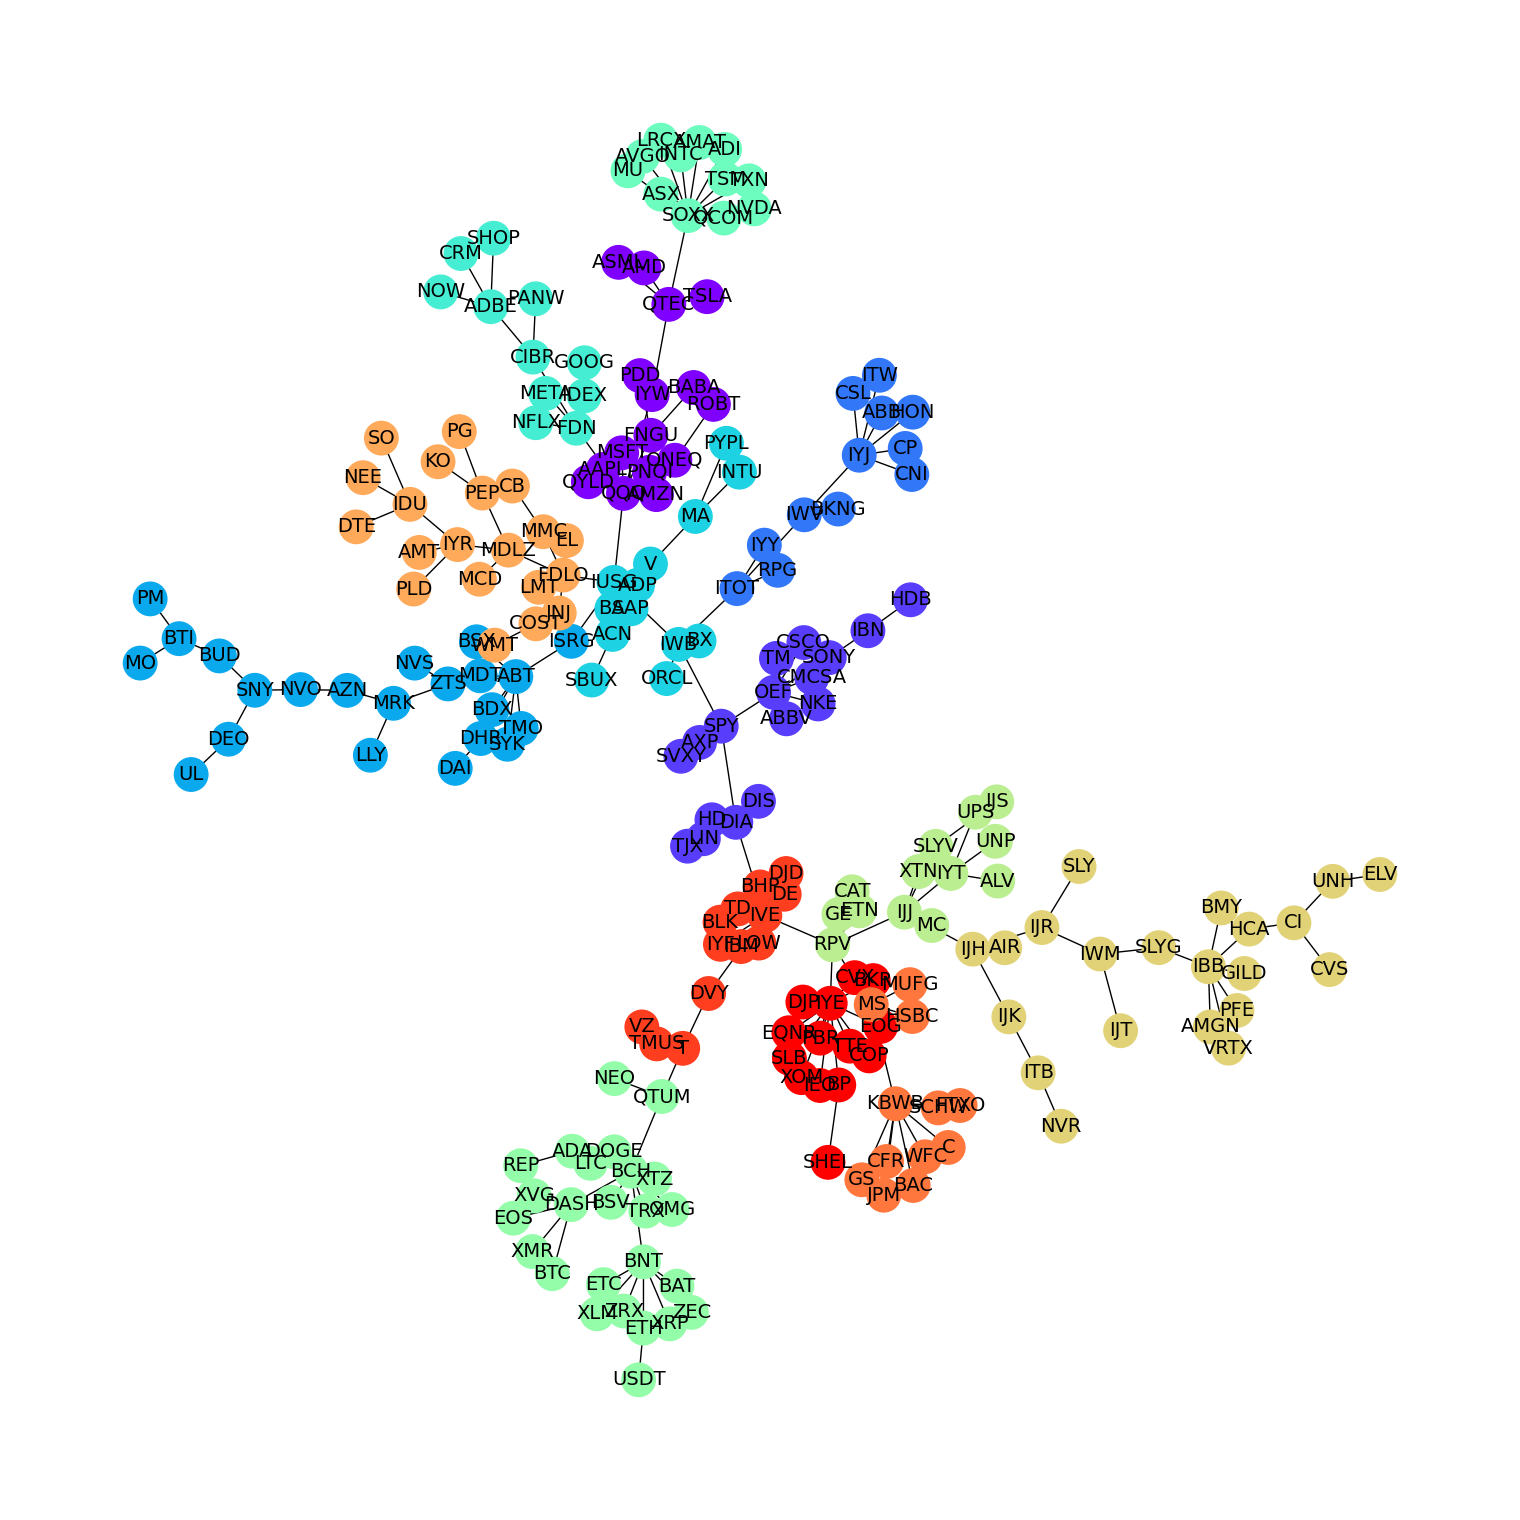

In [ ]:
_,girvan_pre_Covid = pre_Covid.noise_trend_removal_GN("girvan_pre_Covid_221_asset.png")

In [ ]:
generated = process.create_random_timeseries()

In [ ]:
empirical_simulation = process.simulate_eigenvalue_empirical(100)

100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Louvain Processing: 100%|██████████| 1001/1001 [00:09<00:00, 109.28it/s]


max value:  49


<ipython-input-106-0ef4acc2a8d0>:395: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(selected_partition.values()) + 1)


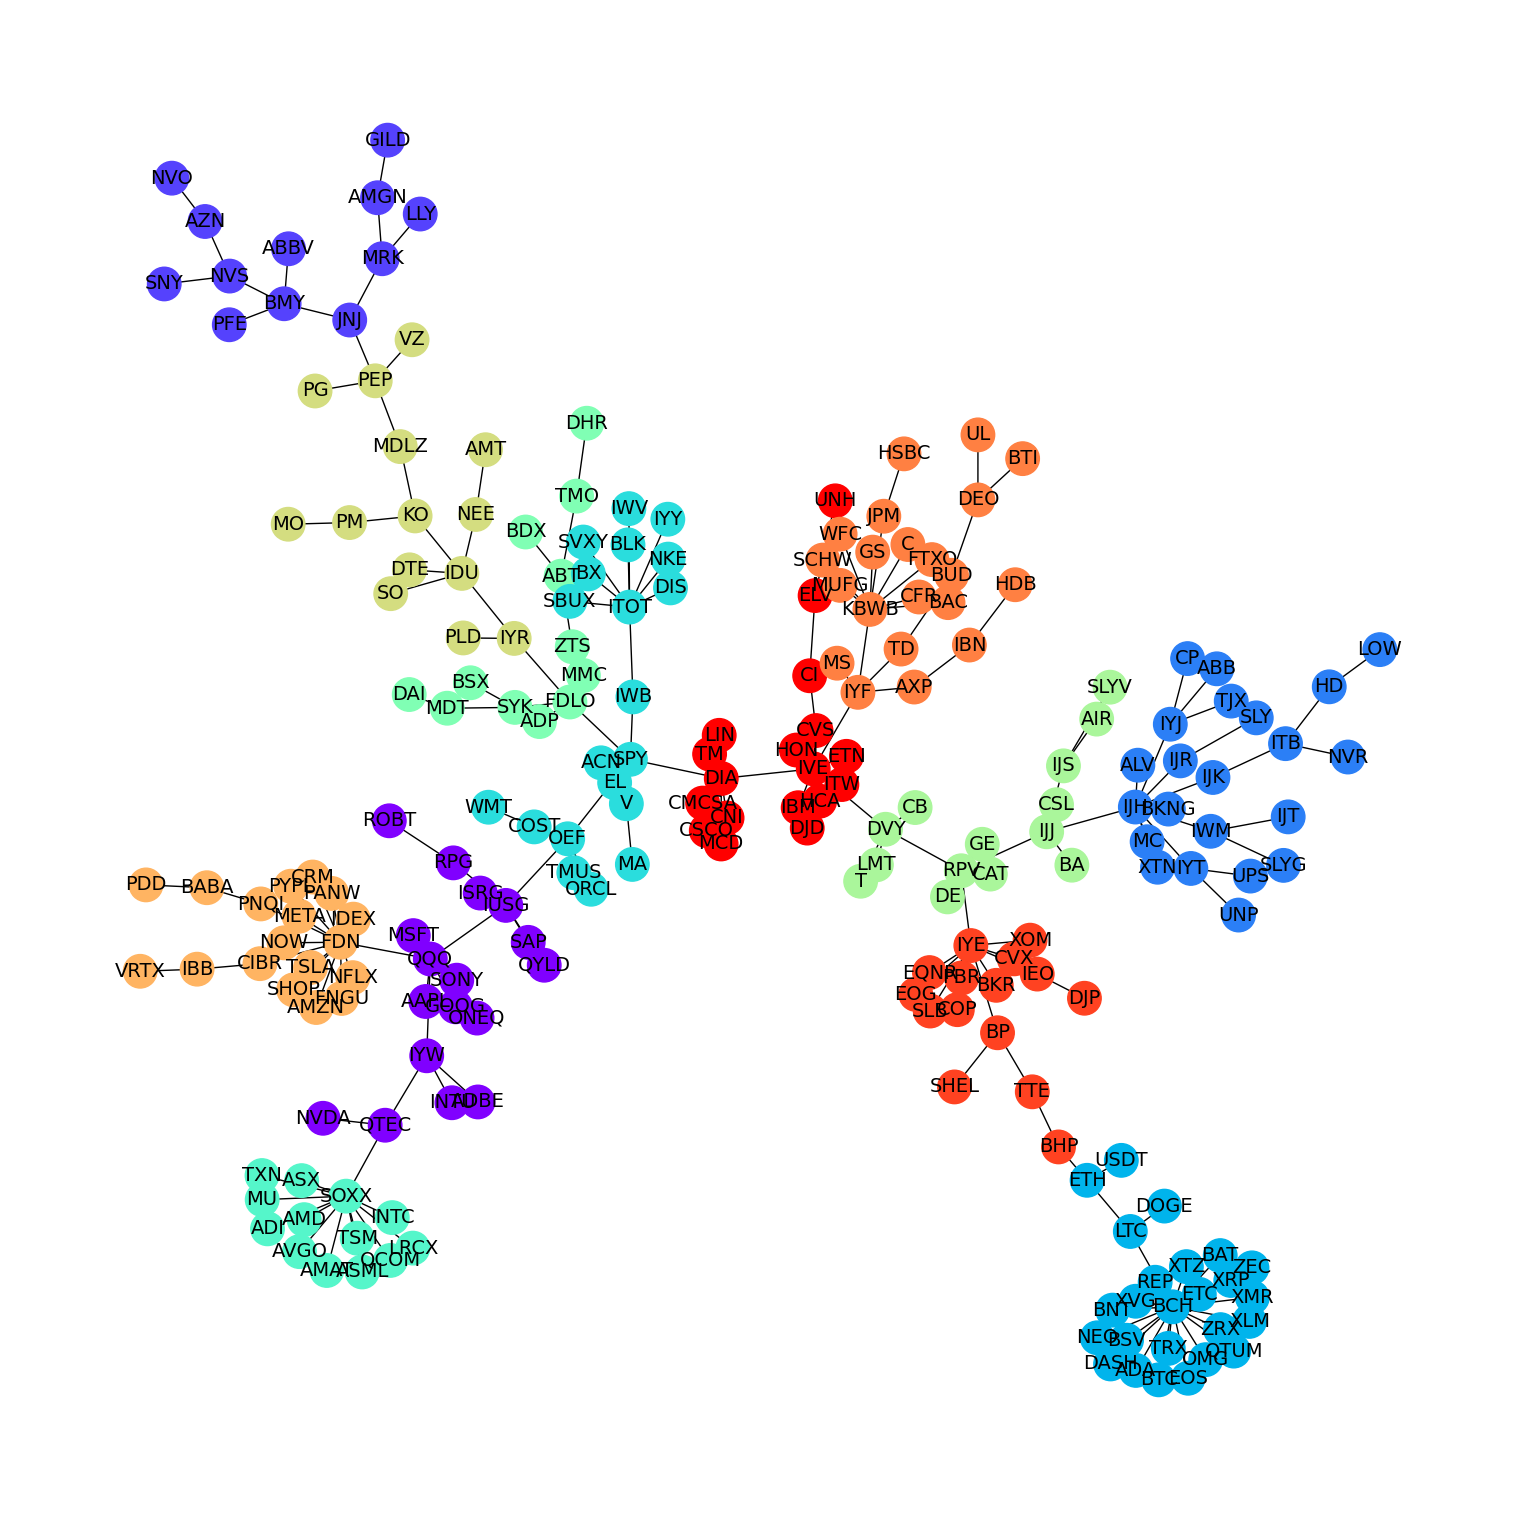

In [ ]:
lv_GN,selected_structure = process.noise_trend_removal_GN(detrend = False, png_file = "new_GN.png")

100%|██████████| 100/100 [00:00<00:00, 1046.90it/s]
<ipython-input-43-a9925b5f723b>:203: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', max(louvain_partition.values()) + 1)


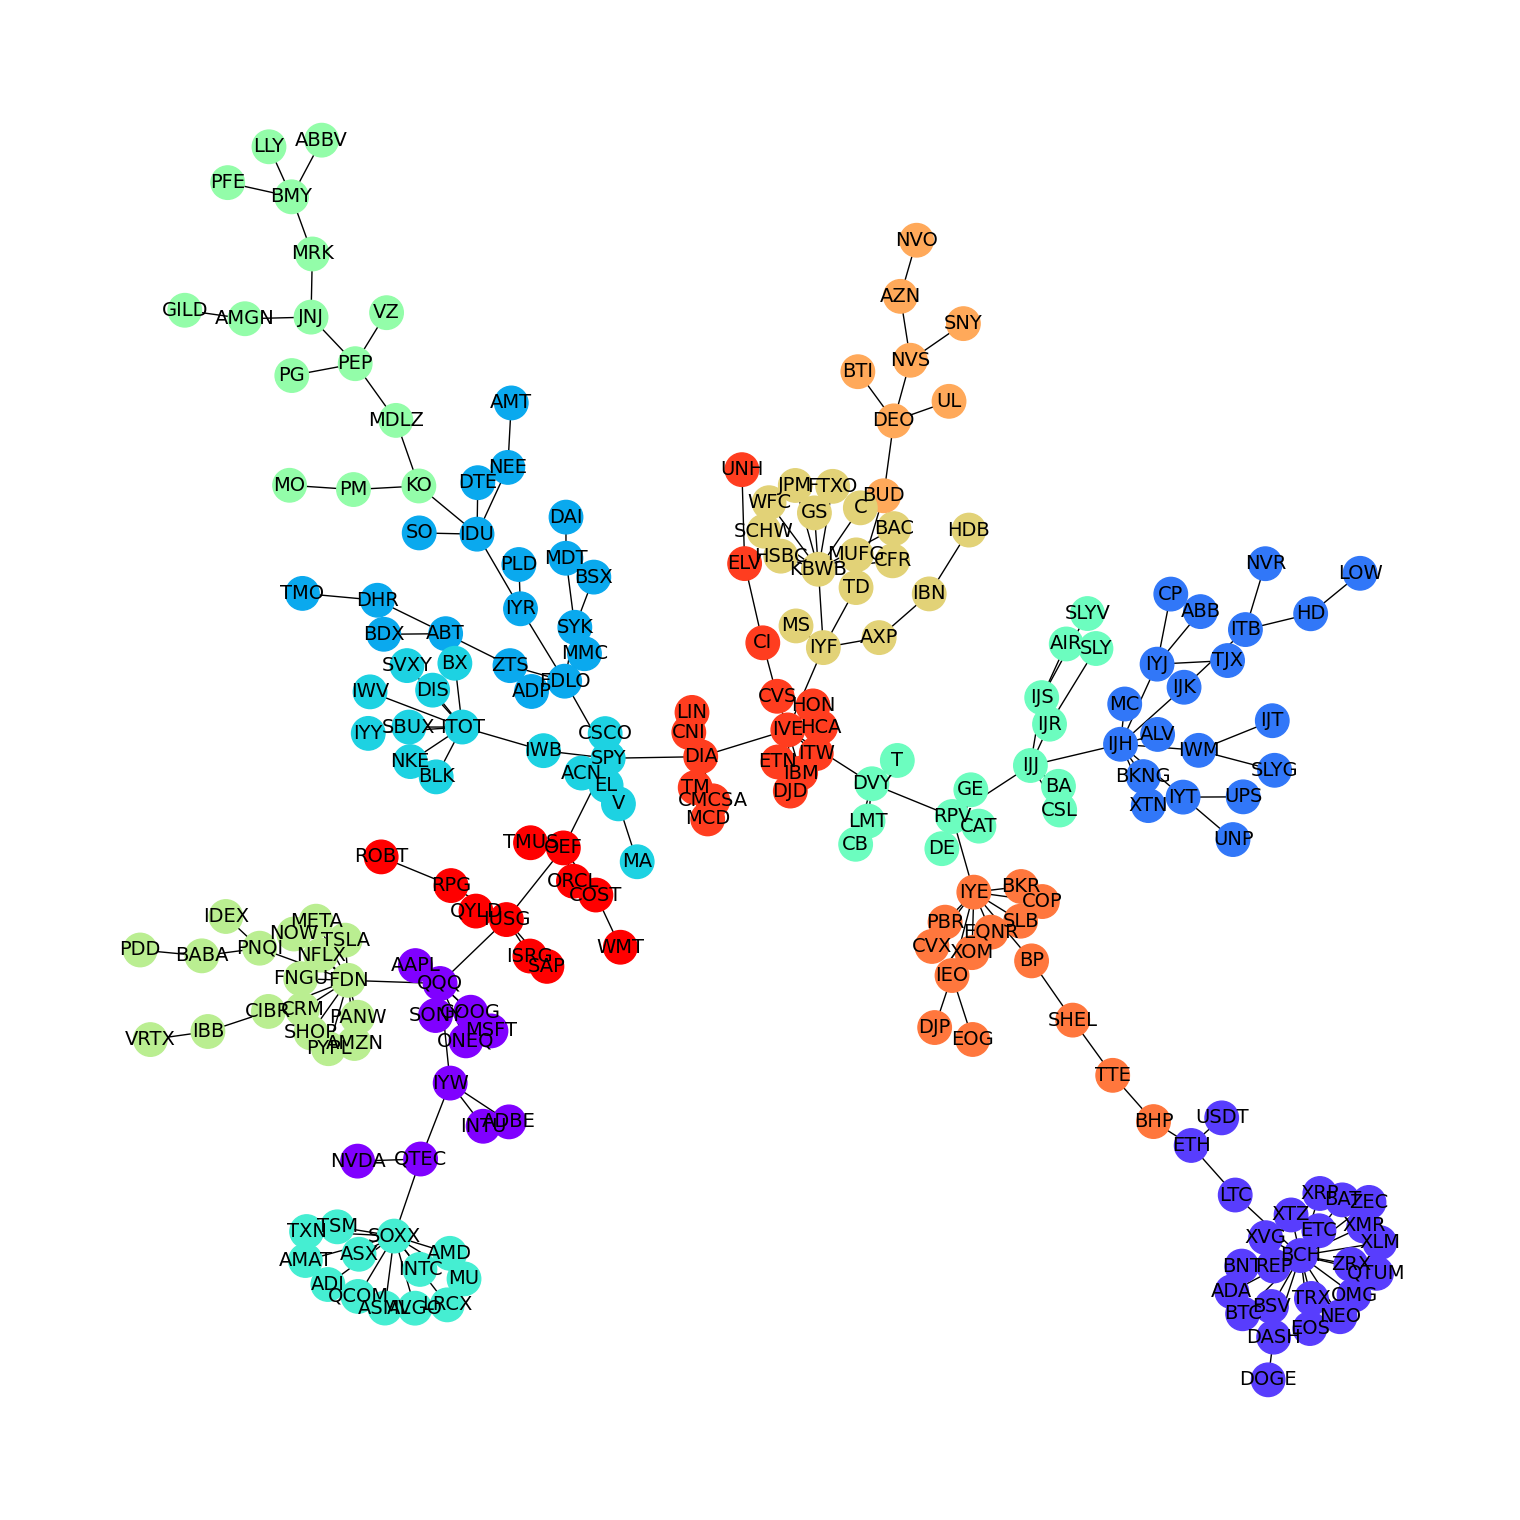

In [ ]:
lv_TW= process.noise_trend_removal_TW_temp("drive/MyDrive/Project_5/eigenvalues/empirical_eig_13360x221_50000.csv",
                                                                                             "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300,
                                                                                             detrend = False, png_file = "new.png")

In [ ]:
lv_TW

{'AAPL': 0,
 'ABBV': 7,
 'ABB': 2,
 'ABT': 3,
 'ACN': 4,
 'ADBE': 0,
 'ADI': 5,
 'ADP': 3,
 'AIR': 6,
 'ALV': 2,
 'AMAT': 5,
 'AMD': 5,
 'AMGN': 7,
 'AMT': 3,
 'AMZN': 8,
 'ASML': 5,
 'ASX': 5,
 'AVGO': 5,
 'AXP': 9,
 'AZN': 10,
 'BABA': 8,
 'BAC': 9,
 'BA': 6,
 'BDX': 3,
 'BHP': 11,
 'BKNG': 2,
 'BKR': 11,
 'BLK': 4,
 'BMY': 7,
 'BP': 11,
 'BSX': 3,
 'BTI': 10,
 'BUD': 10,
 'BX': 4,
 'CAT': 6,
 'CB': 6,
 'CFR': 9,
 'CI': 12,
 'CMCSA': 12,
 'CNI': 12,
 'COP': 11,
 'COST': 13,
 'CP': 2,
 'CRM': 8,
 'CSCO': 4,
 'CSL': 6,
 'CVS': 12,
 'CVX': 11,
 'C': 9,
 'DEO': 10,
 'DE': 6,
 'DHR': 3,
 'DIS': 4,
 'DTE': 3,
 'ELV': 12,
 'EL': 4,
 'EOG': 11,
 'EQNR': 11,
 'ETN': 12,
 'GE': 6,
 'GILD': 7,
 'GOOG': 0,
 'GS': 9,
 'HCA': 12,
 'HDB': 9,
 'HD': 2,
 'HON': 12,
 'HSBC': 9,
 'IBM': 12,
 'IBN': 9,
 'IDEX': 8,
 'INTC': 5,
 'INTU': 0,
 'ISRG': 13,
 'ITW': 12,
 'JNJ': 7,
 'JPM': 9,
 'KO': 7,
 'LIN': 12,
 'LLY': 7,
 'LMT': 6,
 'LOW': 2,
 'LRCX': 5,
 'MA': 4,
 'MCD': 12,
 'MC': 2,
 'MDLZ': 7,
 'MDT': 3,

In [ ]:
lv_TW == lv_TW_b

False

In [ ]:
return_data_func = process.signal_identifier()

In [ ]:
logs = return_data_func.to_numpy()

In [ ]:
lv_TW_all = process.noise_trend_removal_TW("drive/MyDrive/Project_5/eigenvalues/empirical_eig_13360x221_50000.csv", "drive/MyDrive/Project_5/eigenvalues/300_300_50000_eigenvalues.csv", 300, 300)